# Parameterize the kinetic rates of the model

## Conduct a simulation

In [ ]:
# define the environment path 
import os
# local_cobrakbase_path = os.path.join('/Users/afreiburger/Documents')
local_cobrakbase_path = os.path.join('C:', 'Users', 'Andrew Freiburger','Documents','Argonne','cobrakbase')
os.environ["HOME"] = local_cobrakbase_path

# import the models
import cobrakbase
# with open("/Users/afreiburger/Documents/kbase_token.txt") as token_file:
with open("C:/Users/Andrew Freiburger/Documents/Argonne/kbase_token.txt") as token_file:
    kbase_api = cobrakbase.KBaseAPI(token_file.readline())
    
import warnings
warnings.filterwarnings(action='once')

ecoli = kbase_api.get_from_ws("iML1515",76994)

from pandas import set_option
set_option("display.max_rows", None)

In [ ]:
print([met.id for met in ecoli.metabolites if met.compartment == "e0"])

In [ ]:
%run ../../../ModelSEED/ModelSEEDpy/modelseedpy/core/msminimalmedia.py
MSMinimalMedia.minimize_components(ecoli)

In [ ]:
from datetime import datetime
from time import process_time
from pandas import set_option
set_option("display.max_rows", None)
# import the KBase objects
graphs = [
    {
        'trial':'B4',
        'content': 'OD',
        'experimental_data': True
    }
]

%run MSCommFitting.py
time1 = process_time()
mscommfit = MSCommFitting()
mscommfit.load_data(#phenotypes_csv_path = 'PhenotypeStoichiometry.csv', 
                    community_members = {
                        kbase_api.get_from_ws("iML1515",76994): {
                            'name': 'ecoli', 
                            'phenotypes': {#'acetate': kbase_api.get_from_ws('93465/13/1'), 
                                        'malt': {"cpd00179":[-1,-1]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                            }
                        },
                        kbase_api.get_from_ws("iSB1139.kb.gf",30650): {
                            'name': 'pf',
                            'phenotypes': {'acetate': {"cpd00029":[-1,-1]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                                        '4HB': {"cpd00136":[-1,-1]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                            }
                        }
                    },
                    base_media = kbase_api.get_from_ws("93465/19/1"),
                    signal_csv_paths = {'path':'data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx', 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
                    carbon_conc_series = {'rows': {
                        'cpd00136': {'B':0, 'C': 0, 'D': 1, 'E': 1, 'F': 4, 'G': 4},
                        'cpd00179': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
                        }},
                    ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,5,6,7,8,9,10,11,12]}, # 'wells': ['C2', 'G3', 'C12']}
                   # ignore_timesteps = list(range(11,167)),
                    # zip_path='mscomfit.zip'
                   )
time2 = process_time()
print(datetime.today(), (time2-time1)/60, 'minutes later')
mscommfit.define_problem(parameters={
                                    'v':.3,
                                    'cvmin': 100,
                                    'bcv': 100,
                                    'diffpos': 100,
                                    'diffneg': 100
                                    }, 
                         # export_zip_name='for_michaelis_menten.zip', 
                         final_rel_c12_conc = 0.1, 
                         bad_data_timesteps = {"*":"10:"},
                         mets_to_track = ["cpd00179","cpd00029","cpd00136"],
                         zero_start=["cpd00029"])
print(datetime.today())
%time mscommfit.compute(graphs) #, zip_name='simple_full_community.zip')
print('growth Vmax:', mscommfit.parameters['v'], 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')

## Change the parameters

### crude, universal, Vmax

In [ ]:
from itertools import chain
from numpy import linspace

interesting_metabolites = list(chain(*mscommfit.phenotype_met.values()))

for vmax in linspace(.1,.4,10):
    mscommfit.change_parameters(vmax={met:-vmax for met in interesting_metabolites}, export_zip_name='michaelis_menten_edited.zip', extract_zip_name='for_michaelis_menten.zip')
    %time mscommfit.compute(graphs, 'michaelis_menten_edited.zip')
    print(datetime.today())
    print('growth Vmax:', vmax, 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')

### specified trial-time dependent Vmax

In [ ]:
from numpy import linspace

vmax_values = {}
km_values = {}
for var, content in mscommfit.variables.items():
    if isinstance(var, dict):
        for time in content.keys():
            vmax_values[time] = {trial:2.2667 for trial in content2}
            km_values[time] = {trial:2 for trial in content2}

mscommfit.change_parameters(vmax=vmax_values, km=km_values, strain='ecoli_malt', graphs=graphs, export_zip_name='simple_full_community_edited.zip', extract_zip_name='simple_full_community.zip')
%time mscommfit.compute(graphs, 'michaelis_menten_edited.zip')
print(datetime.today())
print('growth Vmax:', vmax, 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')

### Km variability with a constant Vmax

In [ ]:
from itertools import chain
from numpy import linspace

interesting_metabolites = list(chain(*mscommfit.phenotype_met.values()))
# Vmax=0.42 & Km=2 to start, given [maltose]=5, which yields 0.3
vmax = 0.42
for km in linspace(1.5,2.5,10):
    mscommfit.change_parameters(vmax={met:vmax for met in interesting_metabolites}, km={met:km for met in interesting_metabolites}, export_zip_name='michaelis_menten_edited.zip', extract_zip_name='for_michaelis_menten.zip')
    %time mscommfit.compute(graphs, 'michaelis_menten_edited.zip')
    print(datetime.today())
    print('growth Vmax:', vmax, 'objective value:', mscommfit.problem.objective.value, '\n\n\n\n')

In [ ]:
base_media = kbase_api.get_from_ws("93465/19/1")
print(dir(base_media), base_media.path)

# First-phase optimization (alternatively solving for v and b)

In [1]:
# import the models
from cobra.io import load_json_model
ecoli = load_json_model("ecoli.json")
pf = load_json_model("pf.json")
# print(ecoli.optimize())
# print(pf.optimize())

# load the media
# import os
# # local_cobrakbase_path = os.path.join('/Users/afreiburger/Documents')
# local_cobrakbase_path = os.path.join('C:', 'Users', 'Andrew Freiburger','Documents','Argonne','cobrakbase')
# os.environ["HOME"] = local_cobrakbase_path
# import cobrakbase
# # with open("/Users/afreiburger/Documents/kbase_token.txt") as token_file:
# with open("C:/Users/Andrew Freiburger/Documents/Argonne/kbase_token.txt") as token_file:
#     kbase_api = cobrakbase.KBaseAPI(token_file.readline())
    
# load peripheral packages
import warnings
warnings.filterwarnings(action='once')
from pandas import set_option
set_option("display.max_rows", None)
from time import process_time

# Define the standard graphs from each simulation
graphs_list = [
    {
        'trial':'G48',
        "phenotype": '*',
        'content': 'biomass',
        'experimental_data': False
    },
    {
        'trial':'G48',
        'content': "conc",
    },
    {
        'trial':'G48',
        "phenotype": '*',
        "species":["ecoli"],
        'content': 'biomass'
    },
    {
        'trial':'G48',
        'content': 'total_biomass',
        'experimental_data': True
    }
]

def update_graphs(trial, conc):
    graphs = graphs_list.copy()
    for graph in graphs:
        graph["trial"] = trial
    return graphs

In [48]:
%run ./data/standardized_data/datastandardization.py
growth_data_path="data/Jeffs_data/PF-EC 4-29-22 ratios and 4HB changes.xlsx"
time1 = process_time()
experimental_metadata, growth_df, fluxes_df, standardized_carbon_conc, requisite_biomass, trial_name_conversion, data_timestep_hr, simulation_timestep, media_conc = GrowthData.process(
    community_members = {
        ecoli: {
            'name': 'ecoli', 
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, #kbase_api.get_from_ws('93465/13/1'), 
                'malt': {"consumed":["cpd00179"],
                         "excreted":["cpd00029"]} #kbase_api.get_from_ws("93465/23/1")} #'93465/9/1')}   # !!! The phenotype name must align with the experimental IDs for the graphs to find the appropriate data
                }
        },
        pf: {
            'name': 'pf',
            'phenotypes': {
                'acetate': {"consumed":["cpd00029"]}, # kbase_api.get_from_ws("93465/25/1"), #'93465/11/1'), 
                '4HB': {"consumed":["cpd00136"]} # kbase_api.get_from_ws('	93465/27/1')} #93465/15/1')}
                }
        }
    },
    data_paths = {'path':growth_data_path, 'Raw OD(590)':'OD', 'mNeonGreen':'pf', 'mRuby':'ecoli'},
    species_abundances = {
        1:{"ecoli":0, "pf":1},
        2:{"ecoli":1, "pf":50},
        3:{"ecoli":1, "pf":20},
        4:{"ecoli":1, "pf":10},
        5:{"ecoli":1, "pf":3},
        6:{"ecoli":1, "pf":1},
        7:{"ecoli":3, "pf":1},
        8:{"ecoli":10, "pf":1},
        9:{"ecoli":20, "pf":1},
        10:{"ecoli":1, "pf":0},
        11:{"ecoli":0, "pf":0}
      },
    carbon_conc_series = {'rows': {
        'cpd00136': {'B':0, 'C': 0, 'D': 1, 'E': 1, 'F': 4, 'G': 4},
        'cpd00179': {'B':5, 'C': 5, 'D':5, 'E': 5, 'F': 5, 'G': 5},
    }},
    ignore_trials = {'rows': ['C', 'D', 'E', 'F', 'G'], 'columns': [1,2,3,4,5,6,8,9,10,11,12]},
    # ignore_timesteps="10:",  # The 
    species_identities_rows = {
        1:{"ecoli":"mRuby"},
        2:{"ecoli":"ACS"},
        3:{"ecoli":"mRuby"},
        4:{"ecoli":"ACS"},
        5:{"ecoli":"mRuby"},
        6:{"ecoli":"ACS"}
    }
)
print(f"{(process_time()-time1)/60} minutes")
display(requisite_biomass)

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommFitting\data\standardized_data\datastandardization.py:112: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


acetate {'consumed': ['cpd00029']}
malt {'consumed': ['cpd00179'], 'excreted': ['cpd00029']}
acetate {'consumed': ['cpd00029']}
4HB {'consumed': ['cpd00136']}
The model GCF_001612705.1.RAST.mdl is unable to be simulated with pFBA and yields a < None (infeasible). > error.
The ['B2', 'B3', 'B4', 'B5', 'B6', 'B8', 'B9', 'B10', 'B11', 'B12', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12'] trials were dropped from the OD measurements per the ignore_trials parameter.
The [97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,

{'G6': {'ecoli|mRuby': rxn
  EX_cpd00001_e0    1.170480e+01
  EX_cpd00007_e0   -4.500000e+00
  EX_cpd00009_e0   -5.317911e-01
  EX_cpd00011_e0    1.168465e+00
  EX_cpd00013_e0   -6.005719e+00
  EX_cpd00029_e0    7.543605e+00
  EX_cpd00030_e0   -1.956997e-03
  EX_cpd00034_e0   -1.956997e-03
  EX_cpd00047_e0    1.158125e+01
  EX_cpd00048_e0   -1.578879e-01
  EX_cpd00058_e0   -1.956997e-03
  EX_cpd00063_e0   -1.956997e-03
  EX_cpd00067_e0    2.367700e+01
  EX_cpd00099_e0   -1.956997e-03
  EX_cpd00108_e0   -5.309514e-14
  EX_cpd00116_e0    1.956997e-03
  EX_cpd00149_e0   -1.956997e-03
  EX_cpd00179_e0   -4.500000e+00
  EX_cpd00205_e0   -1.956997e-03
  EX_cpd00254_e0   -1.956997e-03
  EX_cpd08023_e0    1.767623e-13
  EX_cpd10515_e0   -5.870991e-03
  EX_cpd10516_e0   -1.956997e-03
  EX_cpd15378_e0    1.956997e-03
  bio               6.973934e-01
  Name: ecoli_malt, dtype: float64,
  'pf|mNeonGreen': rxn
  EX_cpd00001_e0    1.105081e+01
  EX_cpd00007_e0   -4.937609e+00
  EX_cpd00009_e0   -1.8

##### Fit

In [8]:
# !ls '../../../ModelSEEDDatabase/Biochemistry/'

In [42]:
%run mscommfitting.py

maltose_4HB_commfit = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, growth_df, experimental_metadata)
maltose_4HB_commfit.fit(
    parameters={
        'v':.3,
        'cvmin': .1,
        'bcv': 0.0001,
        'diffpos': 100,
        'diffneg': 100
        }, 
     mets_to_track = ["cpd00179","cpd00029"],
     rel_final_conc = {"cpd00179":0.2},
     zero_start=["cpd00029"],
    abs_final_conc={"cpd00029":0.5}, # metabolomics data
       graphs = update_graphs("G6", None), 
     # export_zip_name='for_michaelis_menten.zip', 
     # data_timesteps = {"A3":list(range(10))},
    # msdb_path='../../../ModelSEED/ModelSEEDDatabase'
    msdb_path='../../../ModelSEEDDatabase',
    publishing=True)

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommFitting\mscommfitting.py:79: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


TypeError: 'NoneType' object is not subscriptable

##### Fit_kinetics

In [ ]:
%run mscommfitting.py

maltose_4HB_commfit = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, growth_df, experimental_metadata)
maltose_4HB_commfit.fit_kinetics(
    parameters={
        'v':.3,
        'cvmin': .1,
        'bcv': 0.0001,
        'diffpos': 100,
        'diffneg': 100
        }, 
     mets_to_track = ["cpd00179","cpd00029"],
     rel_final_conc = {"cpd00179":0.2},
     zero_start=["cpd00029"],
    abs_final_conc={"cpd00029":0.5}, # metabolomics data
       graphs = update_graphs("G4", None), 
     # export_zip_name='for_michaelis_menten.zip', 
     # data_timesteps = {"A3":list(range(10))},
    msdb_path='../../../ModelSEEDDatabase',
    publishing=True)

In [ ]:
from math import isclose

print(isclose(1.5178830414797062e-18, 3.0357660829594124e-18, abs_tol=1e-9))

##### Fit Kinetics3

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommFitting\mscommfitting.py:79: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


Done with concentrations and biomass loops: 0.017447916666666667 min
Done with DCC loop: 0.0005208333333333333 min
Done with the DBC & diffc loop: 0.00546875 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.09557291666666666 min
Done exporting the content: 0.06276041666666667 min
starting optimization
graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'4HB', 'acetate', 'stationary', 'malt'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G6'}
graph_1
{'content': 'conc',
 'experimental_data': False,

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'solveKcat.lp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.10598958333333333 min
starting optimization


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'kcat_primals.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'4HB', 'acetate', 'stationary', 'malt'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G6'}
graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179', 'cpd00029'],
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_all species_4HB,acetate,stationary,malt phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_cpd00179,cpd00029_c.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_ecoli_ecoli species_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_all species_OD,pf,ecoli_total_biomass.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


bin1_ecoli_acetate 0.0
4 0.33
bin2_ecoli_acetate 0.0
2.0 0.33
bin3_ecoli_acetate 0.0
1.0 0.33
bin4_ecoli_acetate 0.0
0.5 0.33
bin5_ecoli_acetate 0.0
0.25 0.33
bin1_ecoli_malt 1.0
bin2_ecoli_malt 1.0
bin3_ecoli_malt 1.0
bin4_ecoli_malt 0.0
0.5 0.33
bin5_ecoli_malt 1.0
bin1_pf_acetate 1.0
bin2_pf_acetate 1.0
bin3_pf_acetate 1.0
bin4_pf_acetate 1.0
bin5_pf_acetate 0.0
0.25 0.0033000000000000004
bin1_pf_4HB 1.0
bin2_pf_4HB 1.0
bin3_pf_4HB 1.0
bin4_pf_4HB 1.0
bin5_pf_4HB 0.0
0.25 36.3363
Done simulating with the coefficients for biomass partitions: 1
1.60234375 minutes
{'ecoli': {'acetate': 2.5575, 'malt': 0.165},
 'pf': {'4HB': 9.084075, 'acetate': 0.0008250000000000001}}
Done with concentrations and biomass loops: 0.06015625 min
Done with DCC loop: 0.0005208333333333333 min
Done with the DBC & diffc loop: 0.005208333333333333 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.09817708333333333 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'solveKcat.lp'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.0625 min
starting optimization


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'kcat_primals.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


graph_0
{'content': 'biomass',
 'experimental_data': False,
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 'dotted',
                     'name': 'P. fluorescens'}},
 'parsed': False,
 'phenotype': {'4HB', 'acetate', 'stationary', 'malt'},
 'species': ['OD', 'pf', 'ecoli'],
 'trial': 'G6'}
graph_1
{'content': 'conc',
 'experimental_data': False,
 'mets': ['cpd00179', 'cpd00029'],
 'painting': {'OD': {'color': 'blue',
                     'linestyle': 'solid',
                     'name': 'Total biomass'},
              'ecoli': {'color': 'red',
                        'linestyle': 'dashed',
                        'name': 'E. coli'},
              'pf': {'color': 'green',
                     'linestyle': 

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_all species_4HB,acetate,stationary,malt phenotypes_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_cpd00179,cpd00029_c.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_ecoli_ecoli species_b_.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'G6_all species_OD,pf,ecoli_total_biomass.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


bin1_ecoli_acetate 0.0
0.5 2.5575
bin2_ecoli_acetate 0.0
0.25 2.5575
bin3_ecoli_acetate 0.0
0.125 2.5575
bin4_ecoli_acetate 0.0
0.0625 2.5575
bin5_ecoli_acetate 0.0
0.03125 2.5575
bin1_ecoli_malt 0.0
0.5 0.165
bin2_ecoli_malt 0.0
0.25 0.165
bin3_ecoli_malt 0.0
0.125 0.165
bin4_ecoli_malt 0.0
0.0625 0.165
bin5_ecoli_malt 0.0
0.03125 0.165
bin1_pf_acetate 1.0
bin2_pf_acetate 1.0
bin3_pf_acetate 1.0
bin4_pf_acetate 1.0
bin5_pf_acetate 0.0
0.03125 0.0008250000000000001
bin1_pf_4HB 1.0
bin2_pf_4HB 0.0
0.25 9.084075
bin3_pf_4HB 0.0
0.125 9.084075
bin4_pf_4HB 0.0
0.0625 9.084075
bin5_pf_4HB 0.0
0.03125 9.084075
Done simulating with the coefficients for biomass partitions: 2
0.7197916666666667 minutes
{'ecoli': {'acetate': 2.477578125, 'malt': 0.15984375},
 'pf': {'4HB': 4.258160156250001, 'acetate': 2.5781250000000003e-05}}


{}

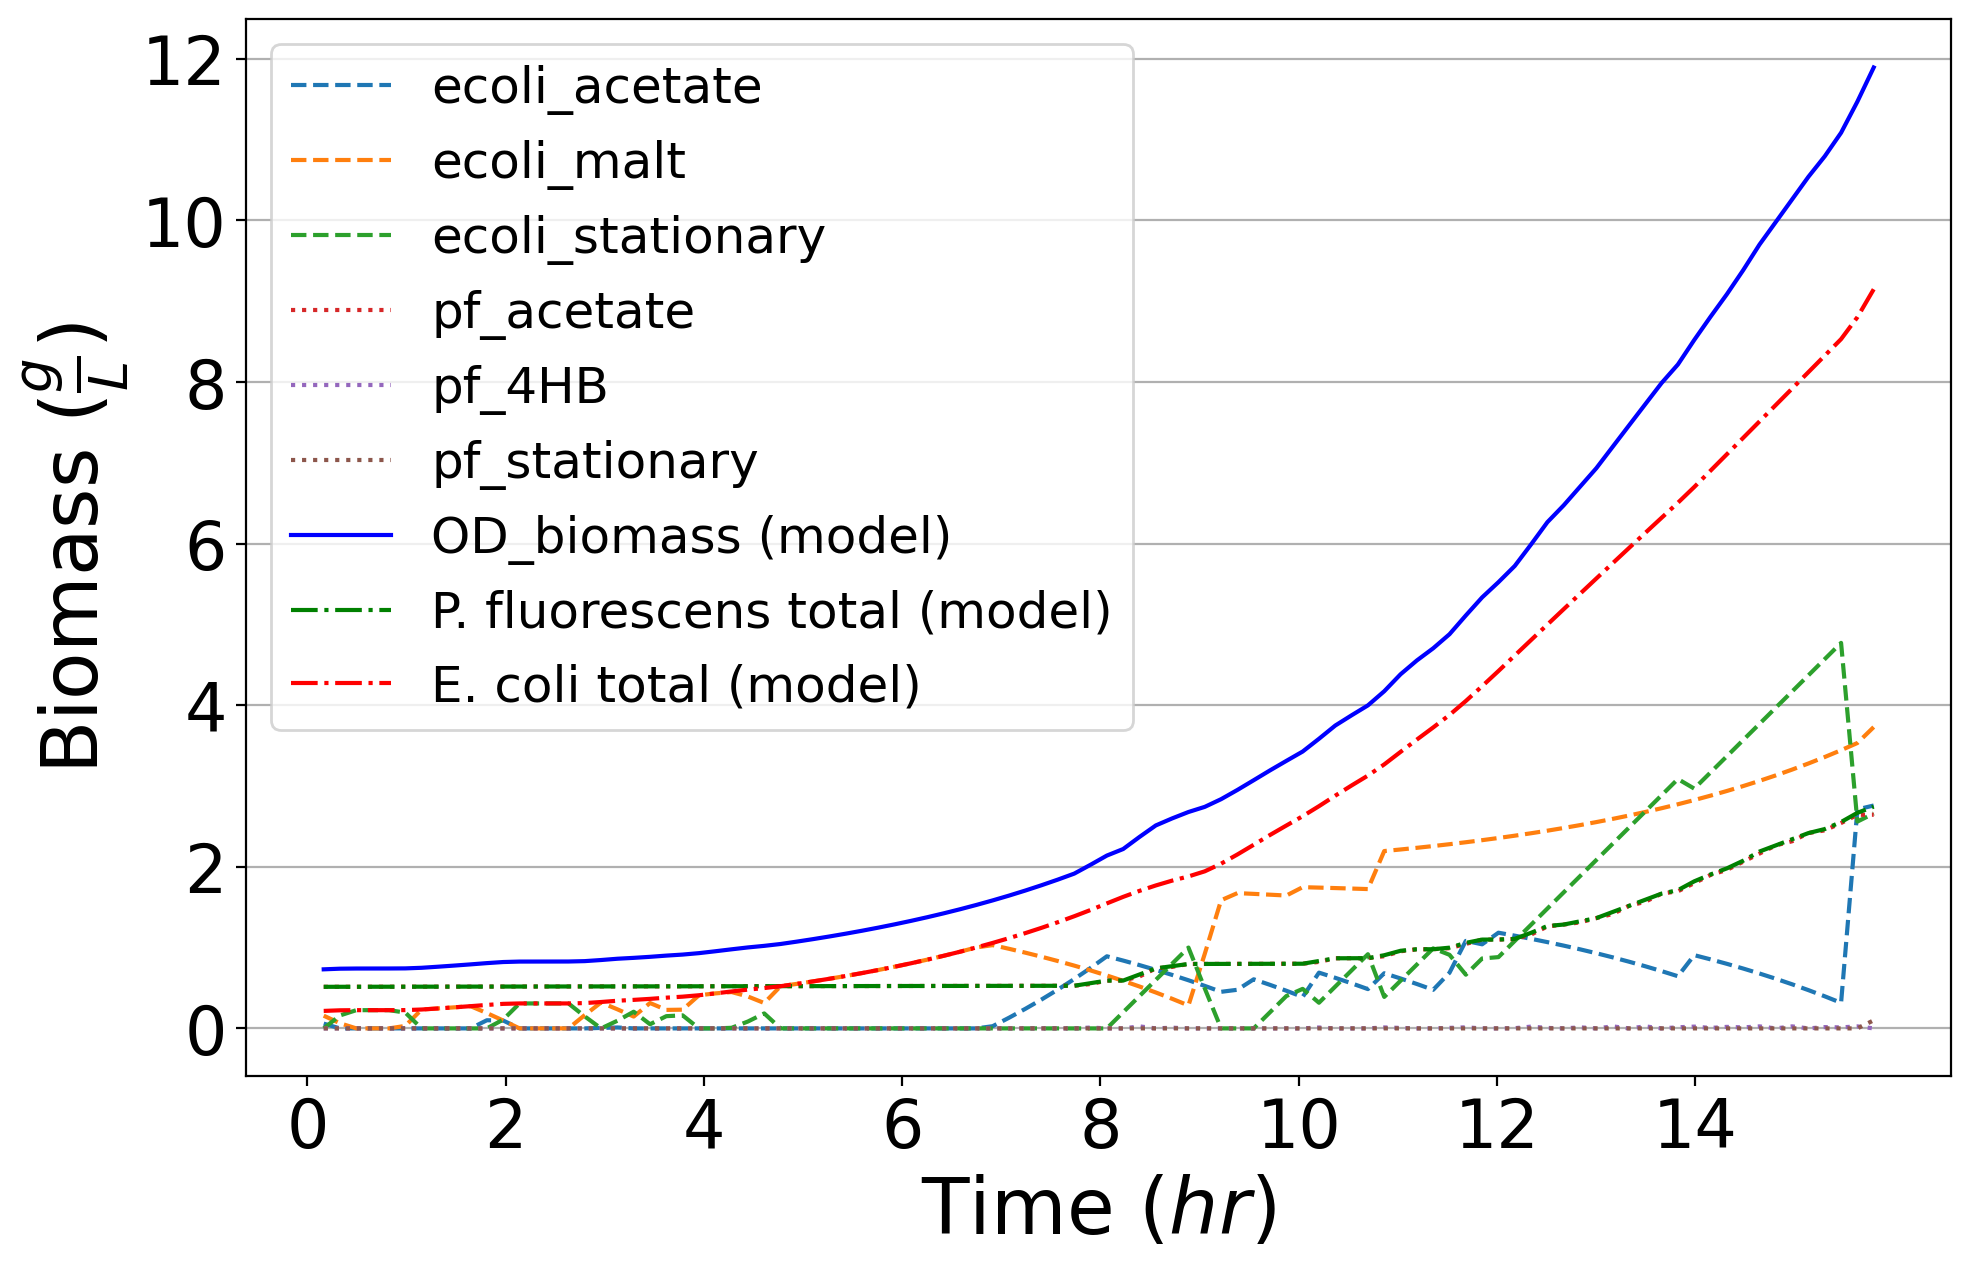

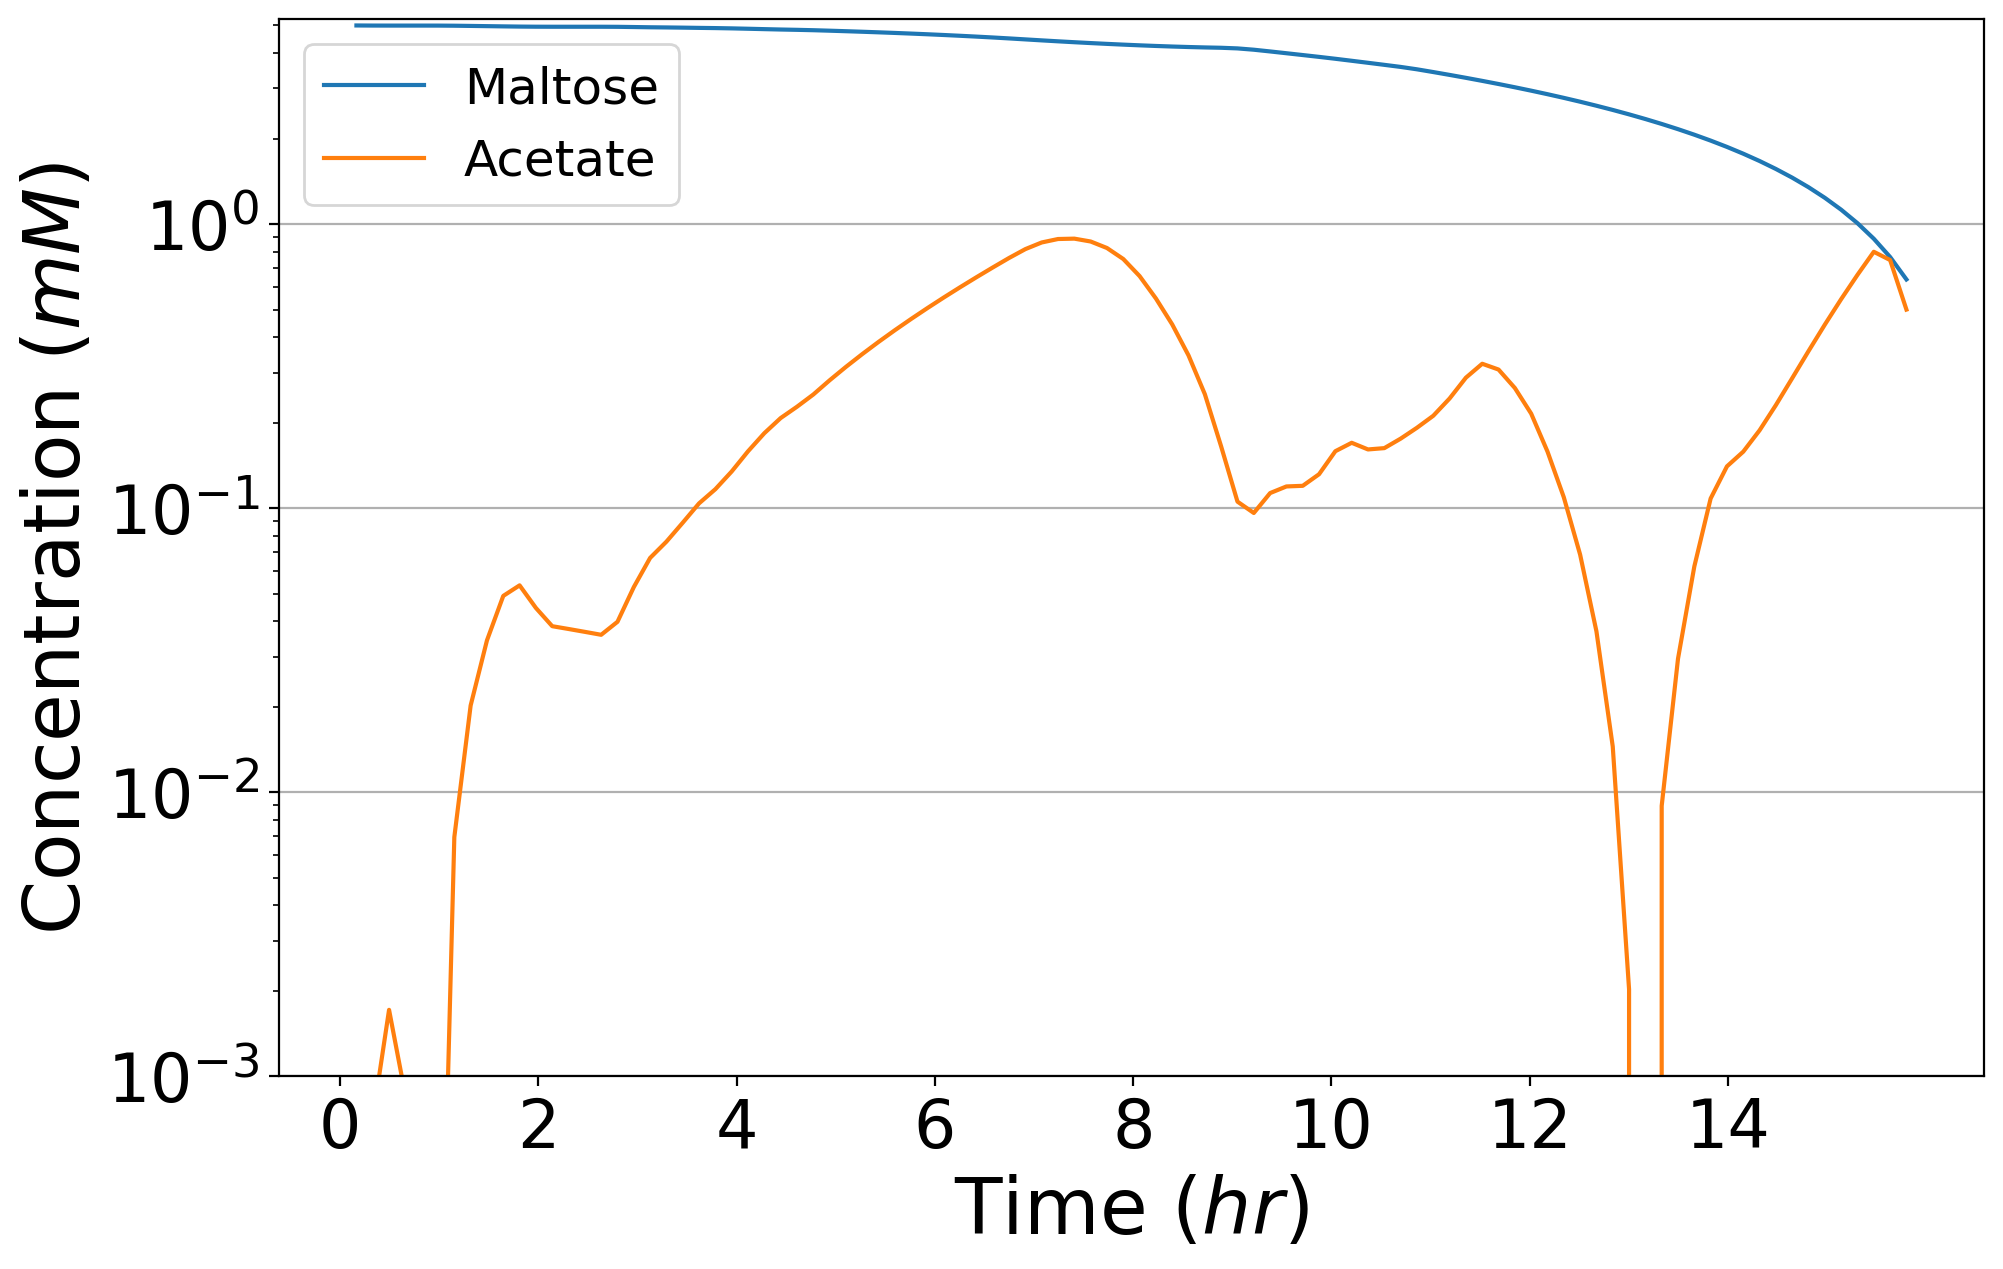

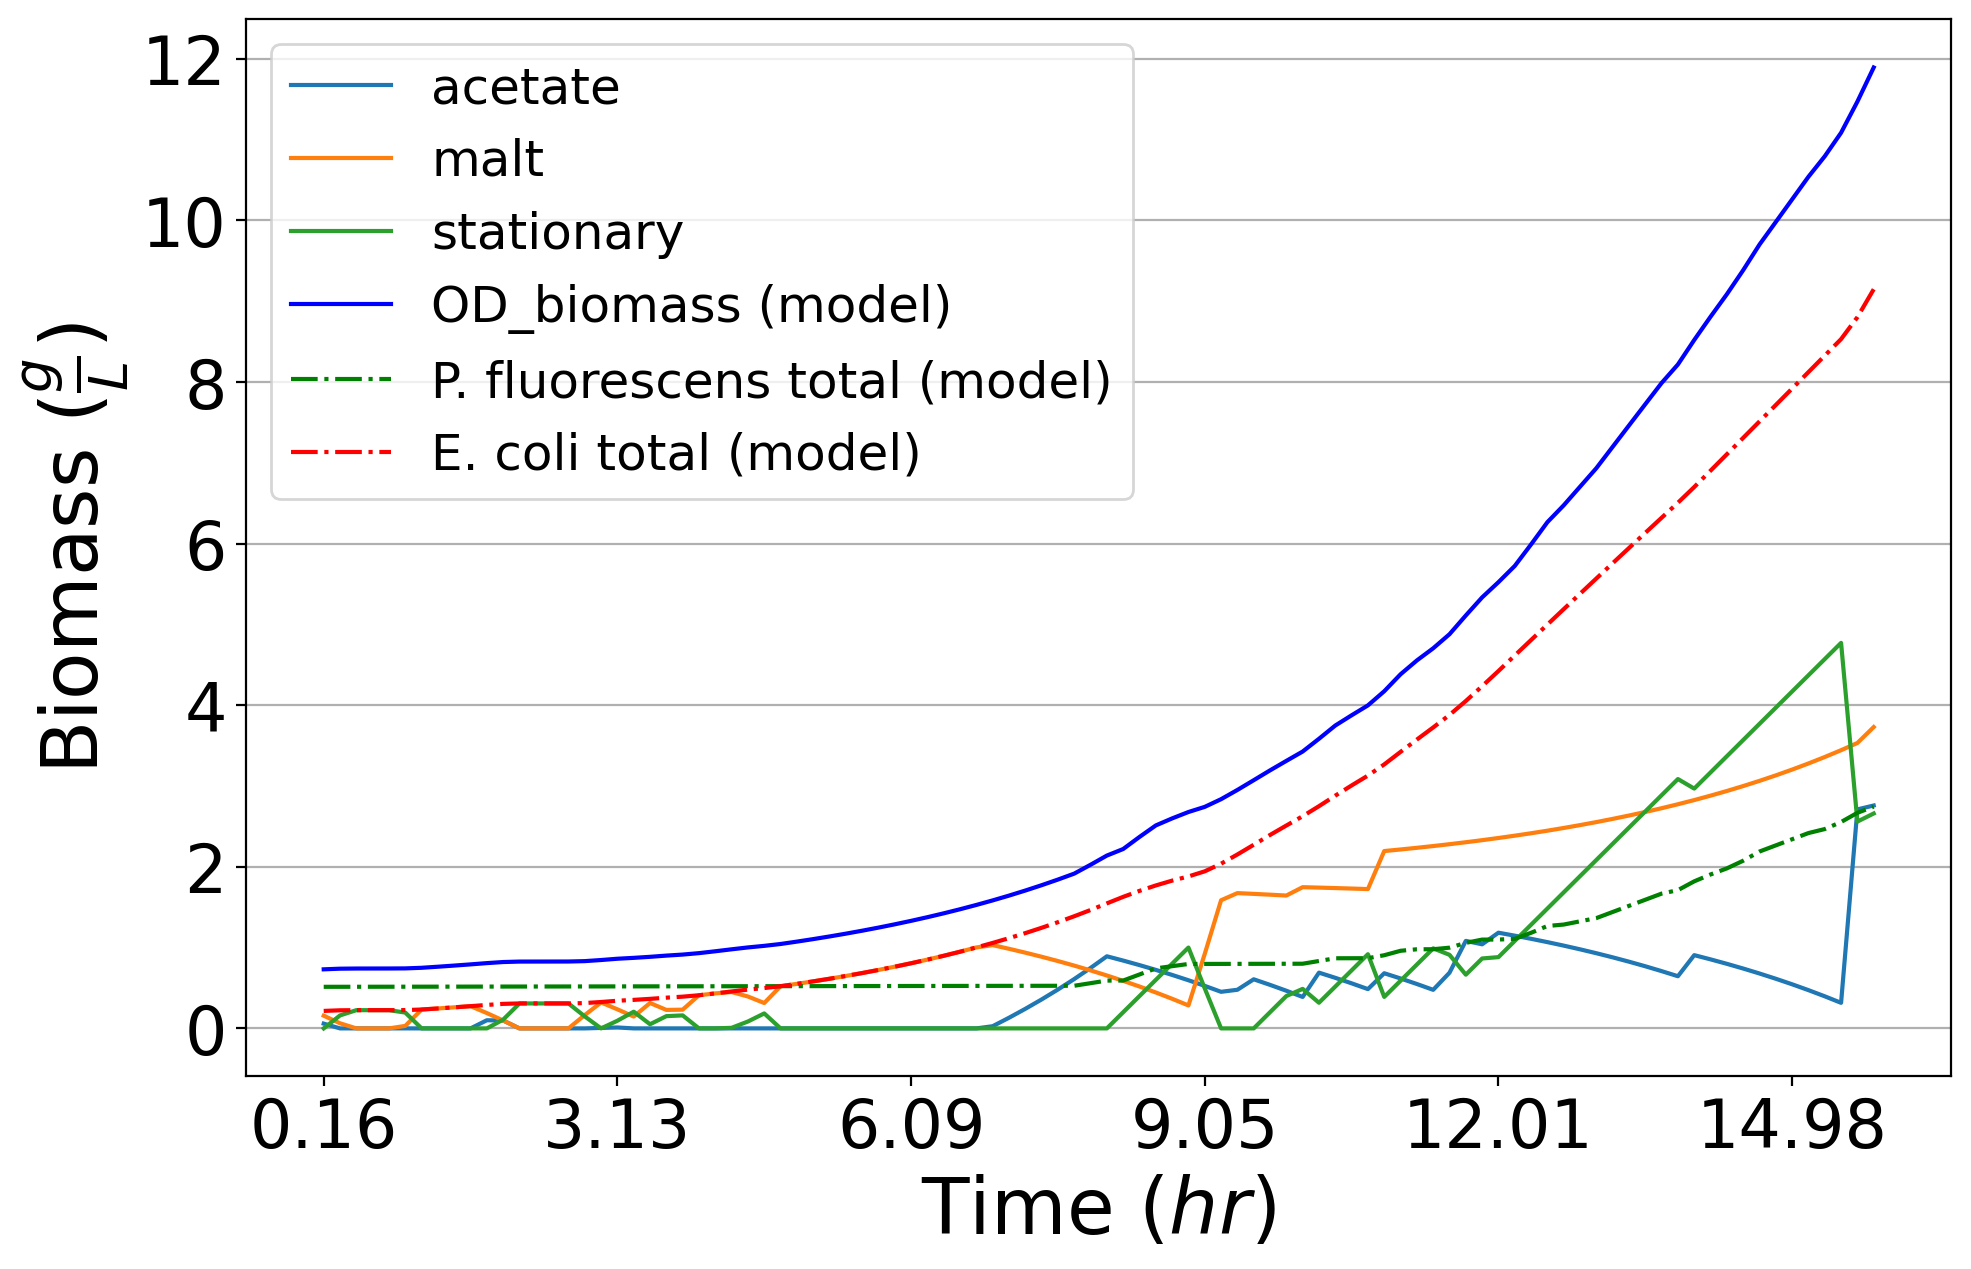

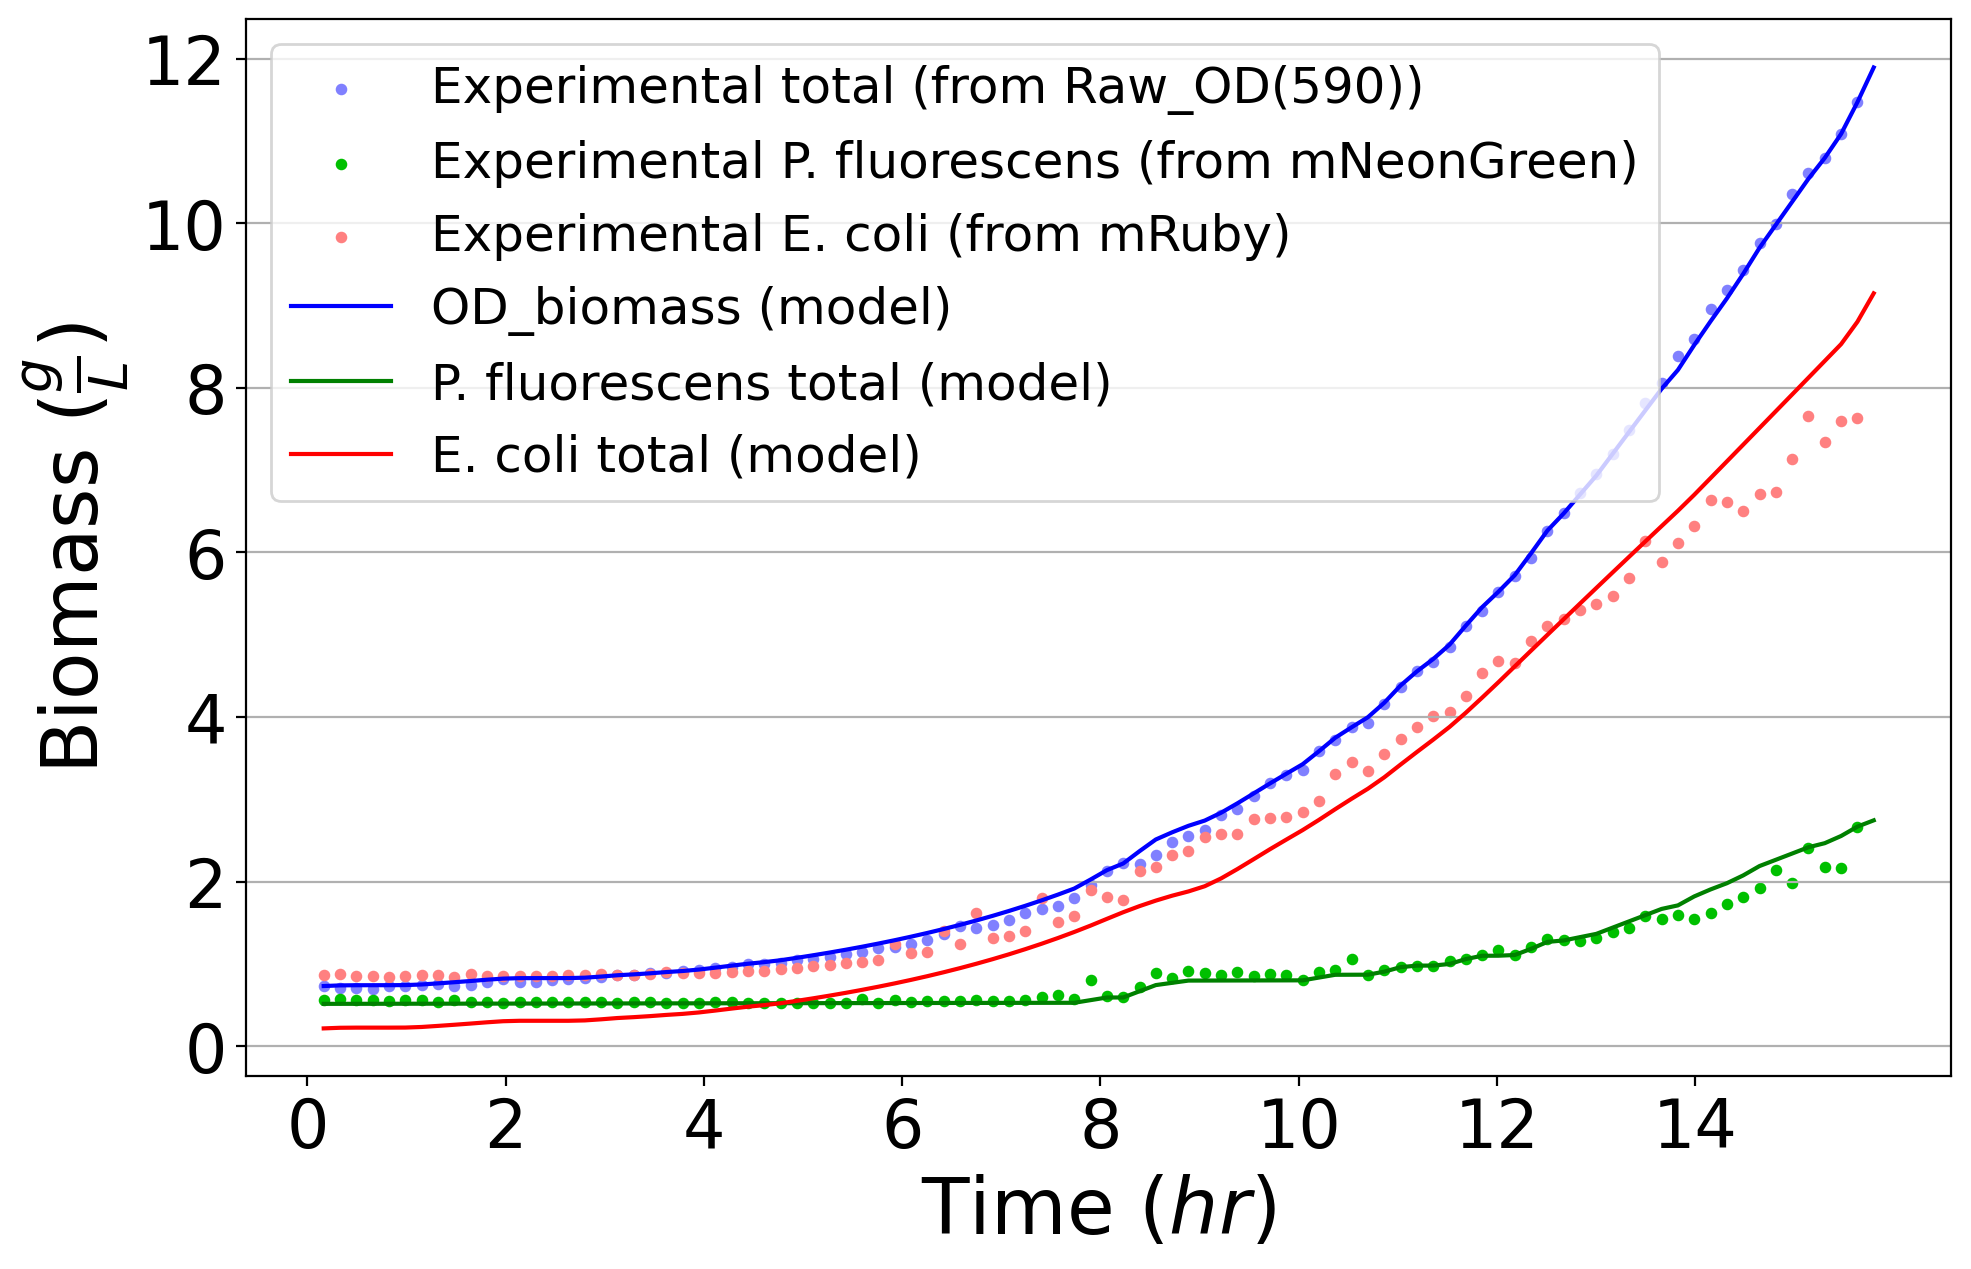

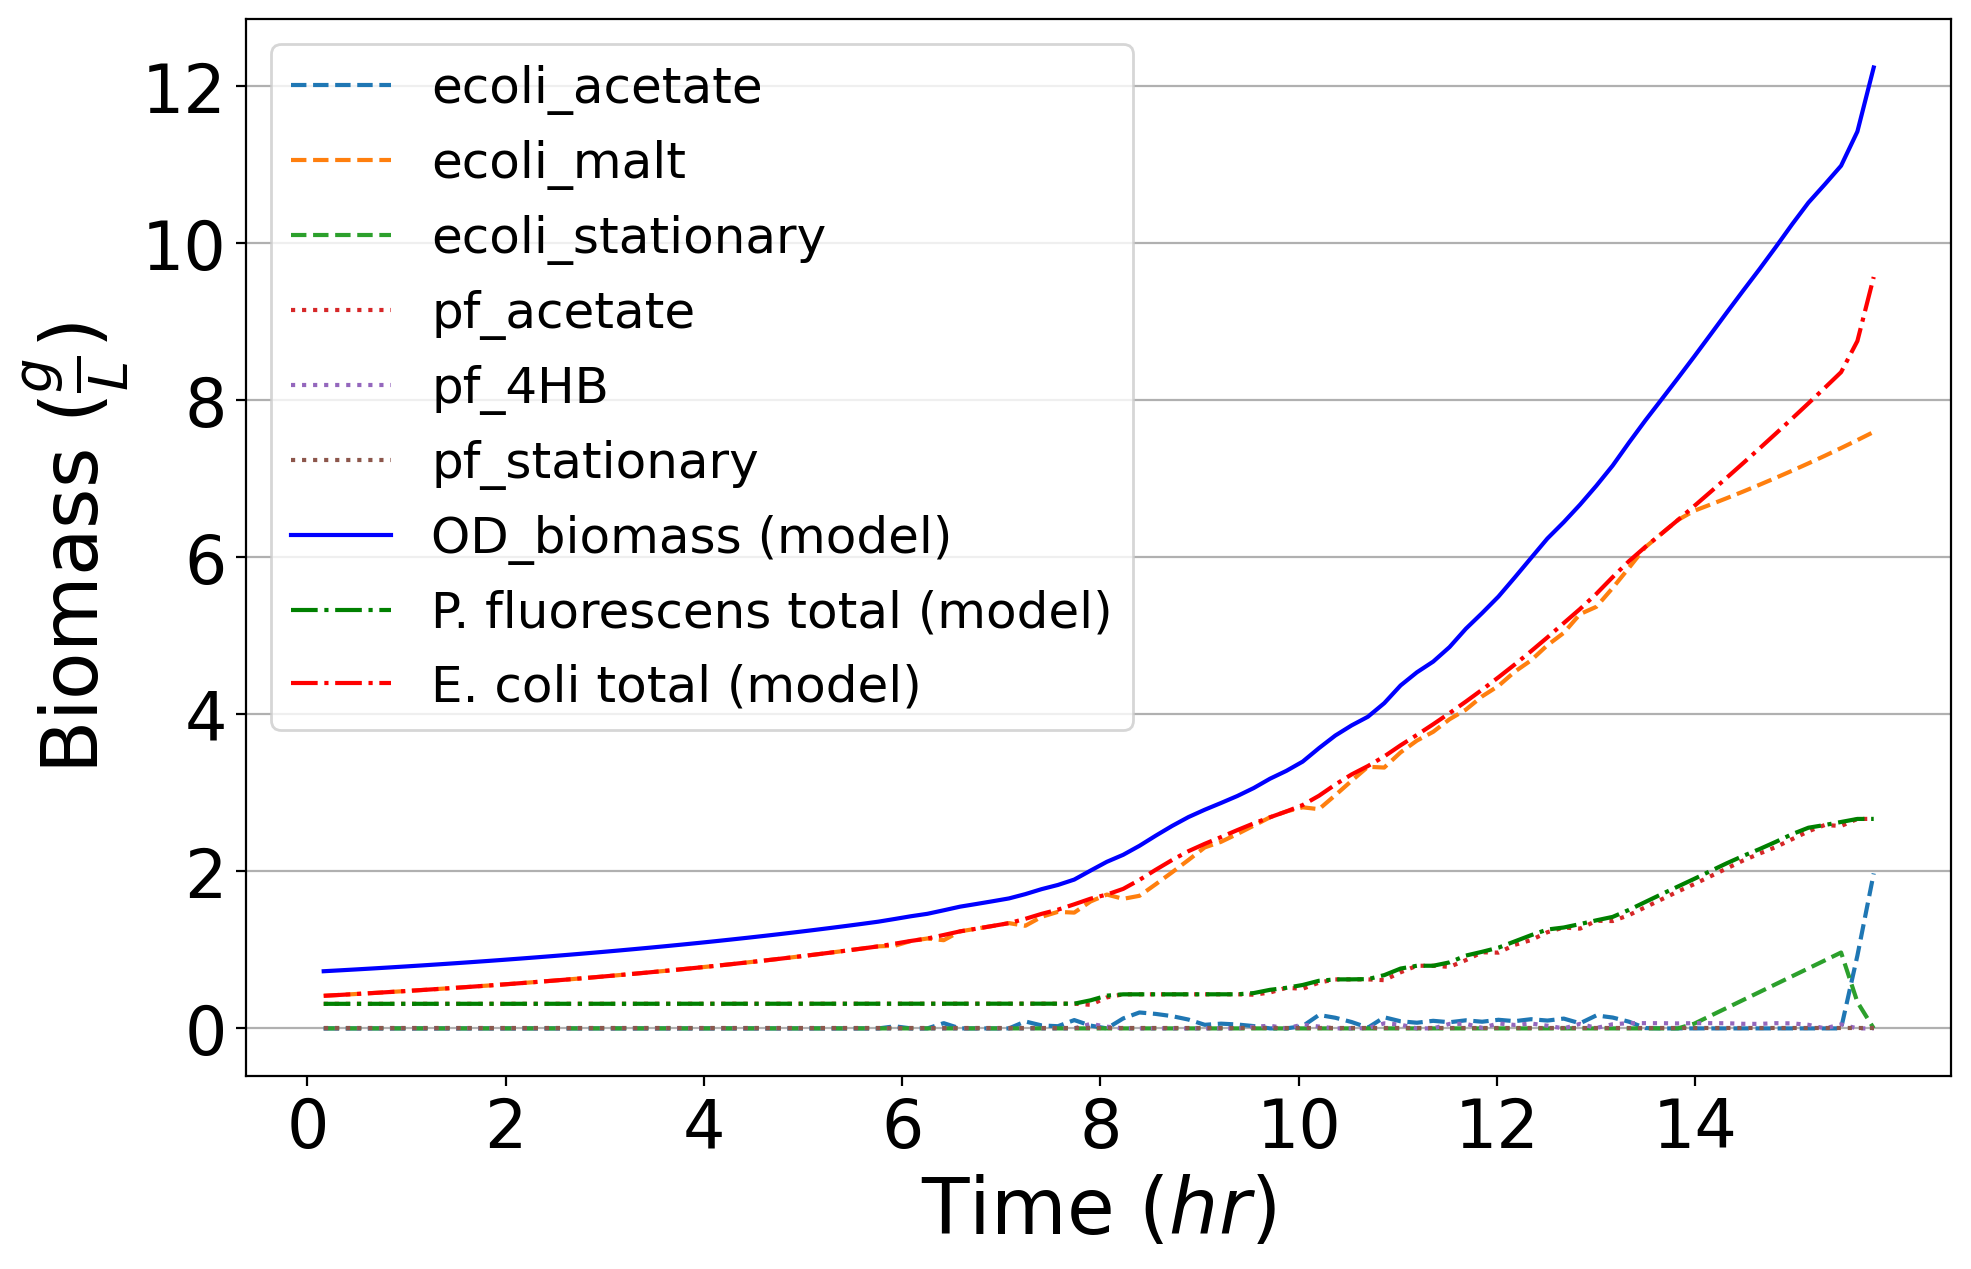

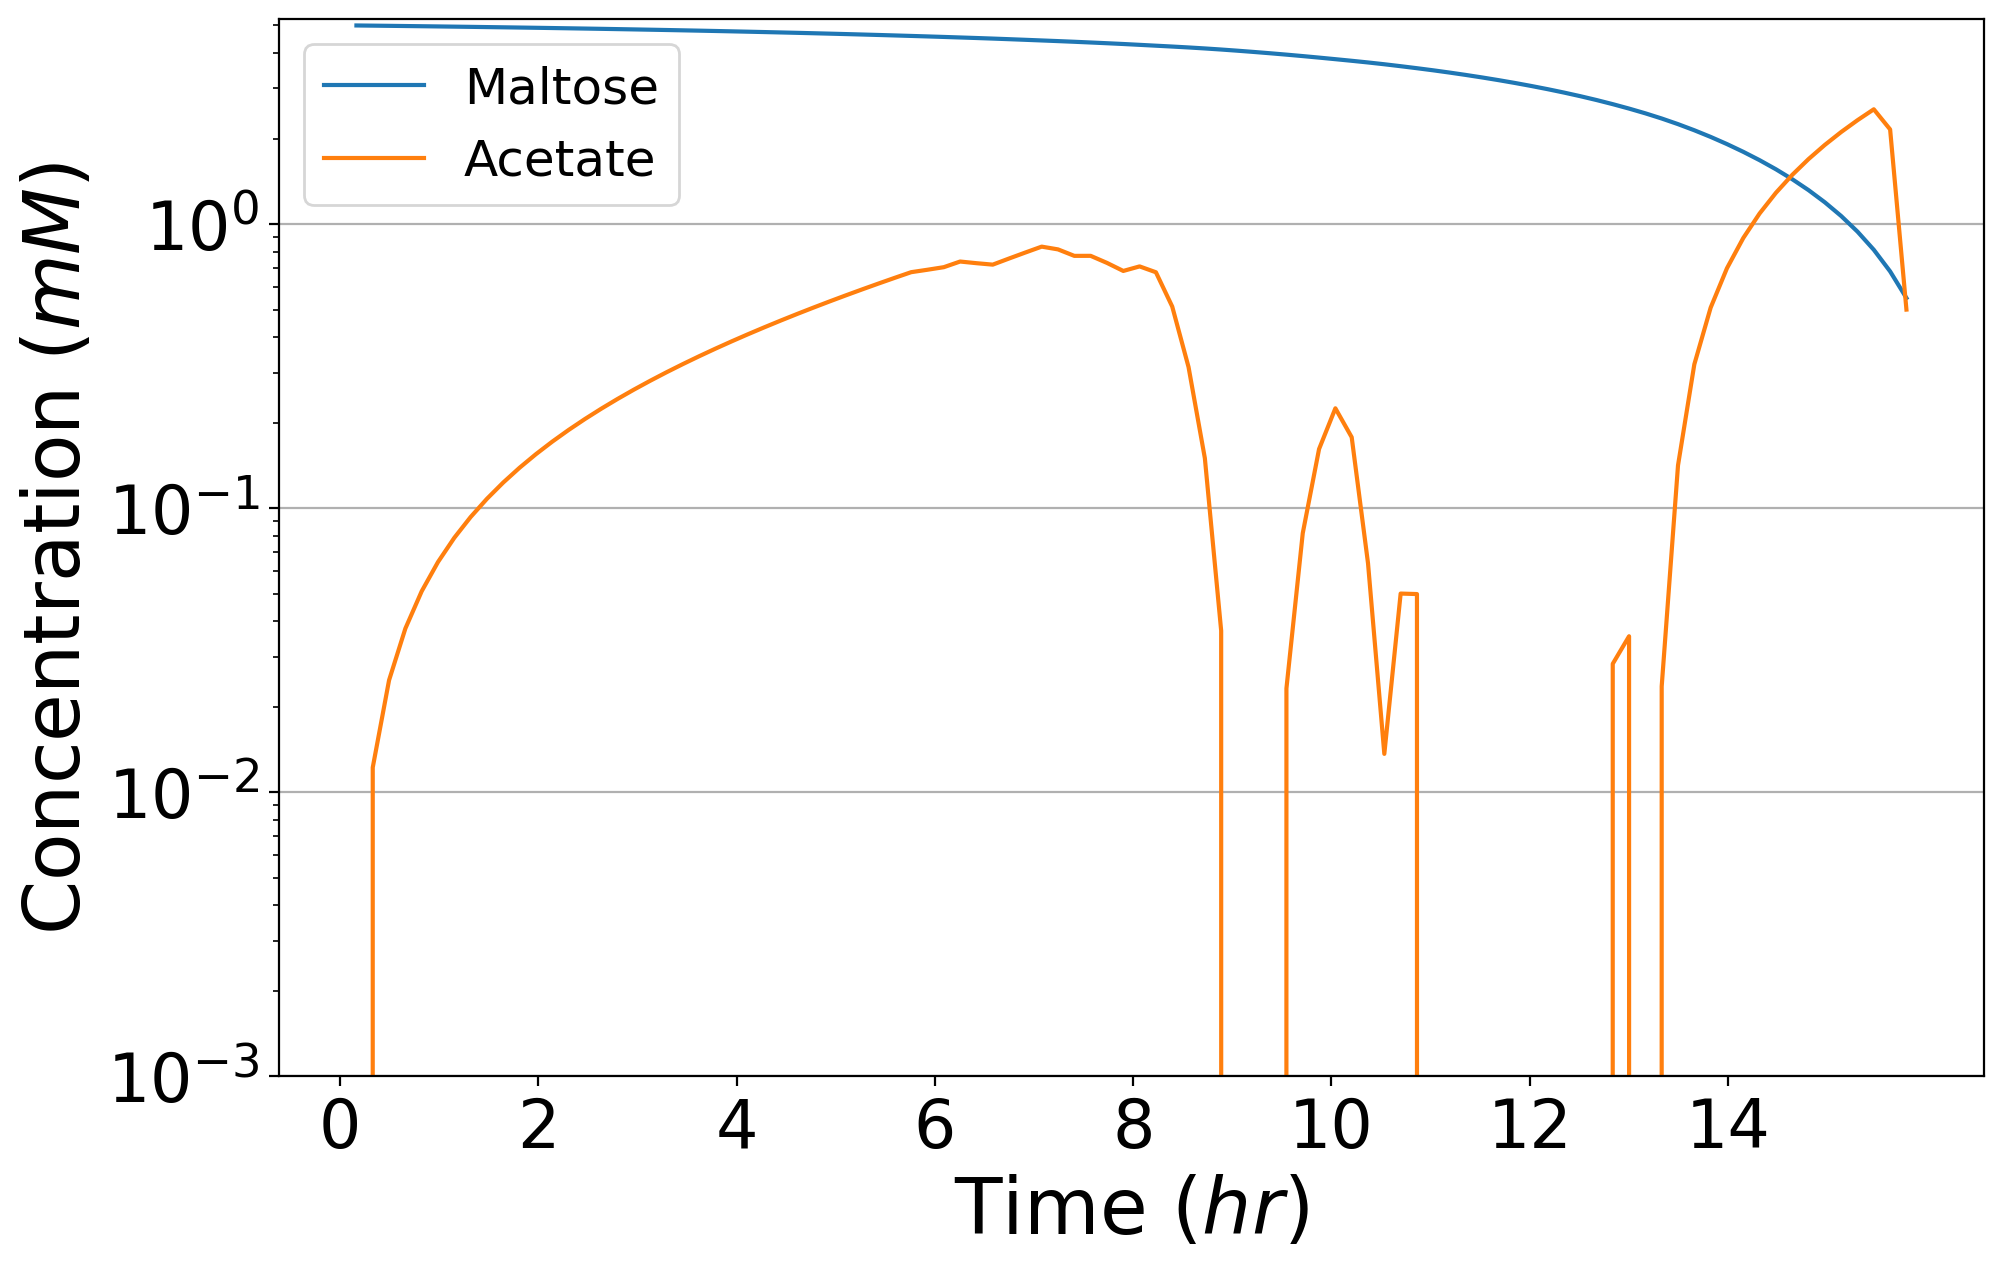

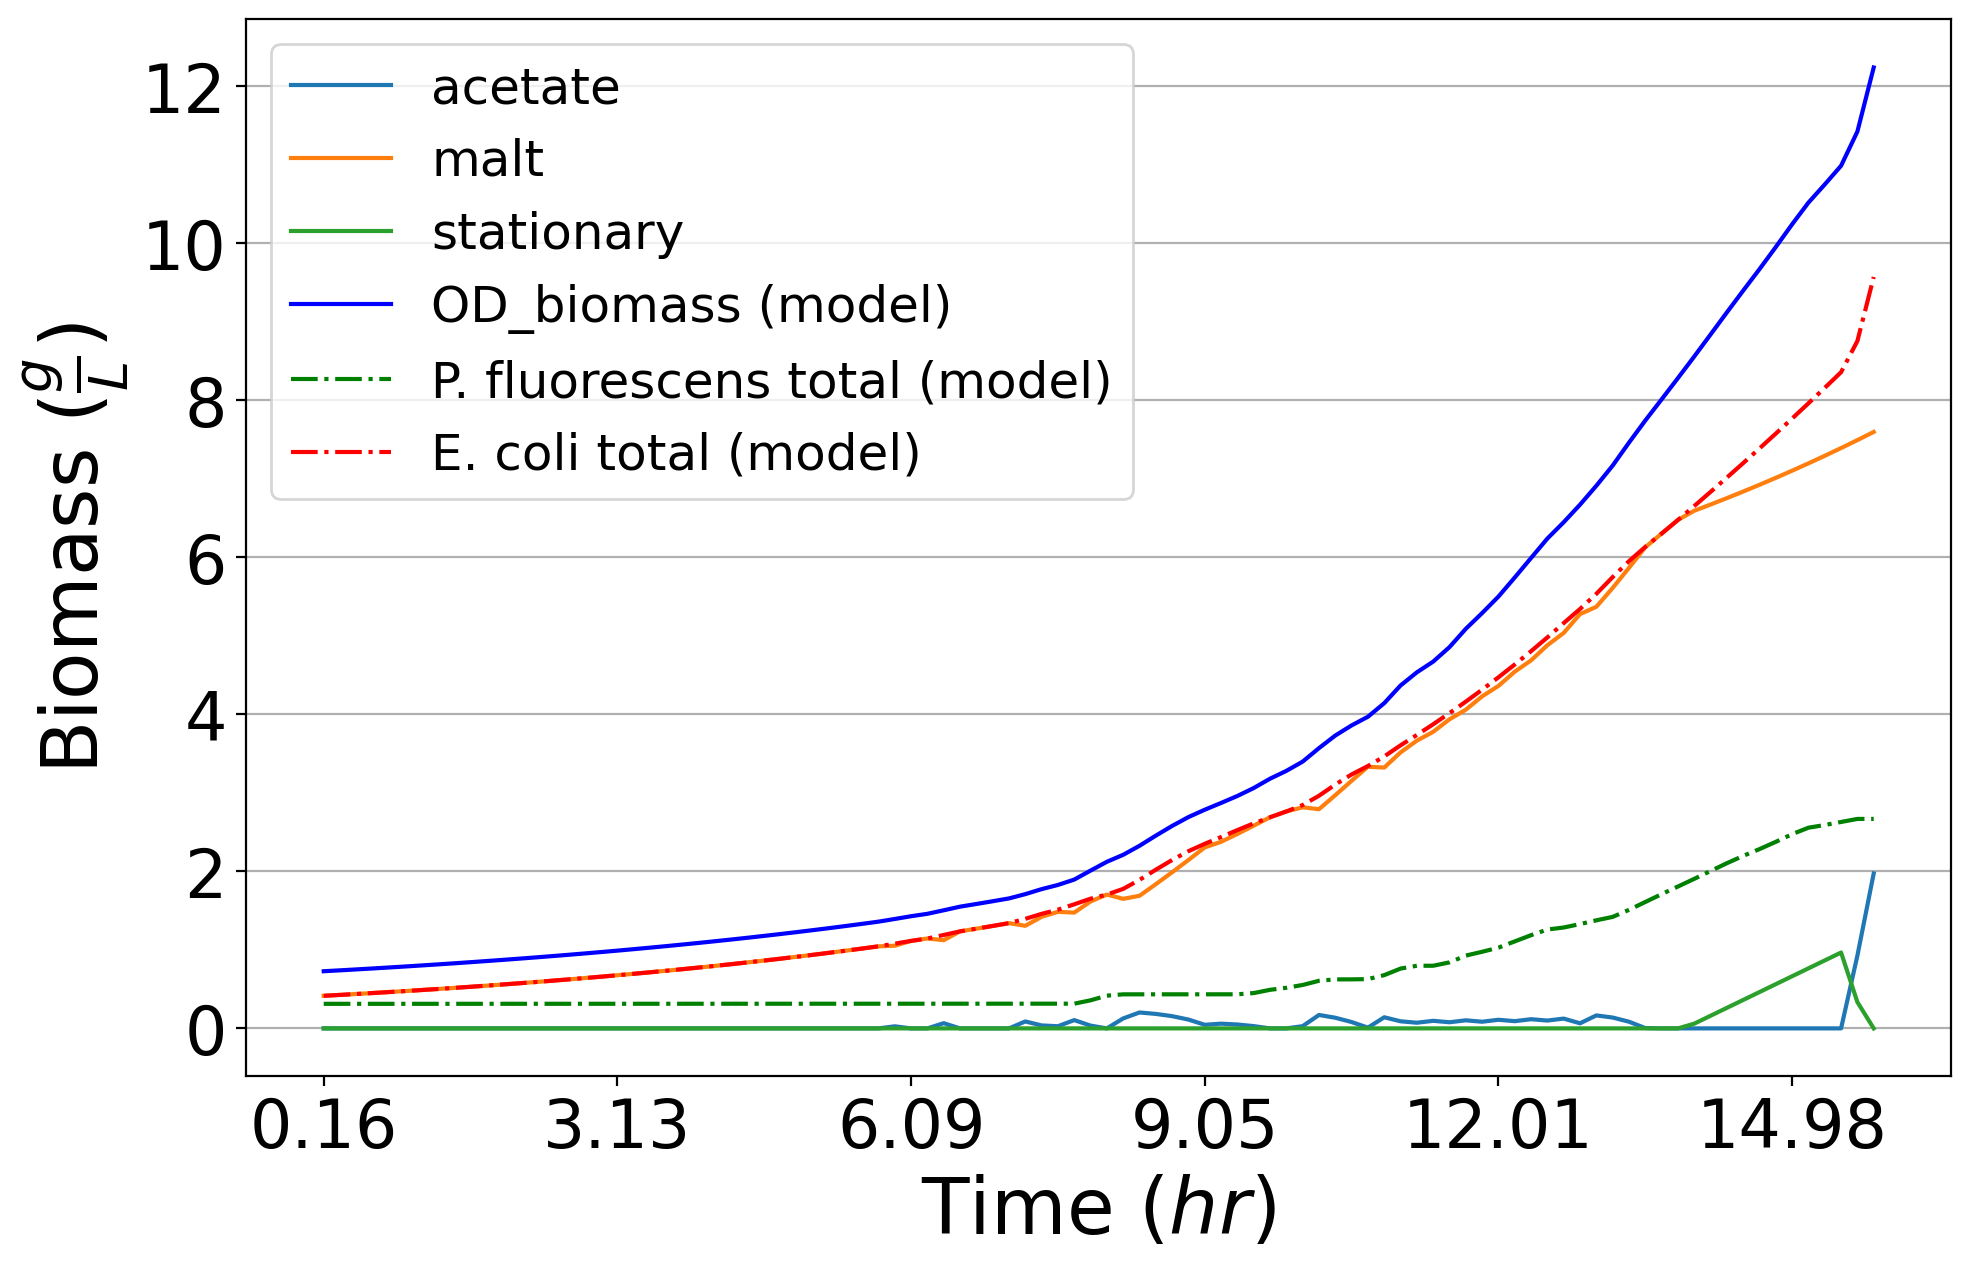

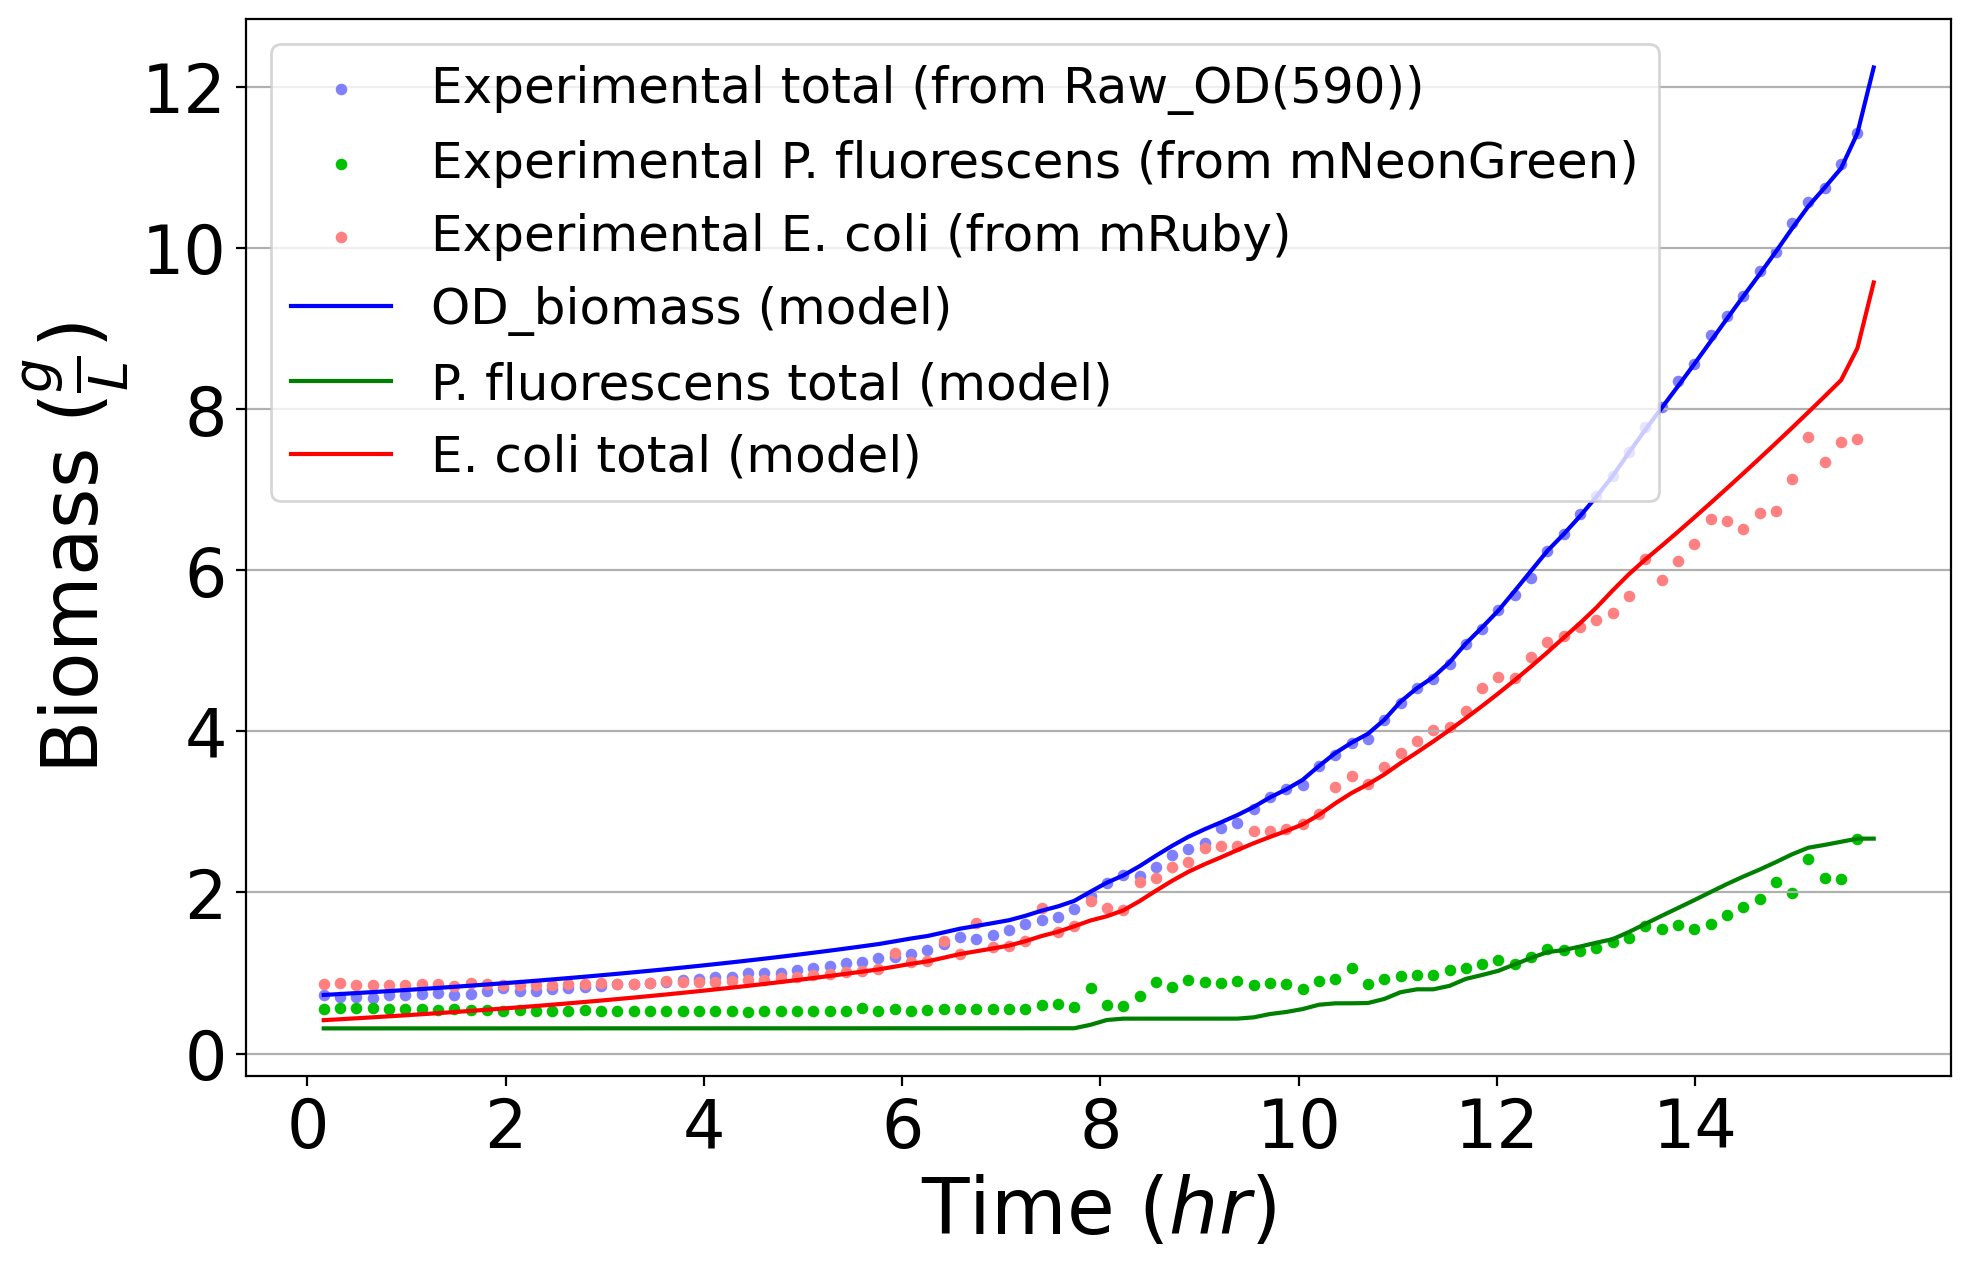

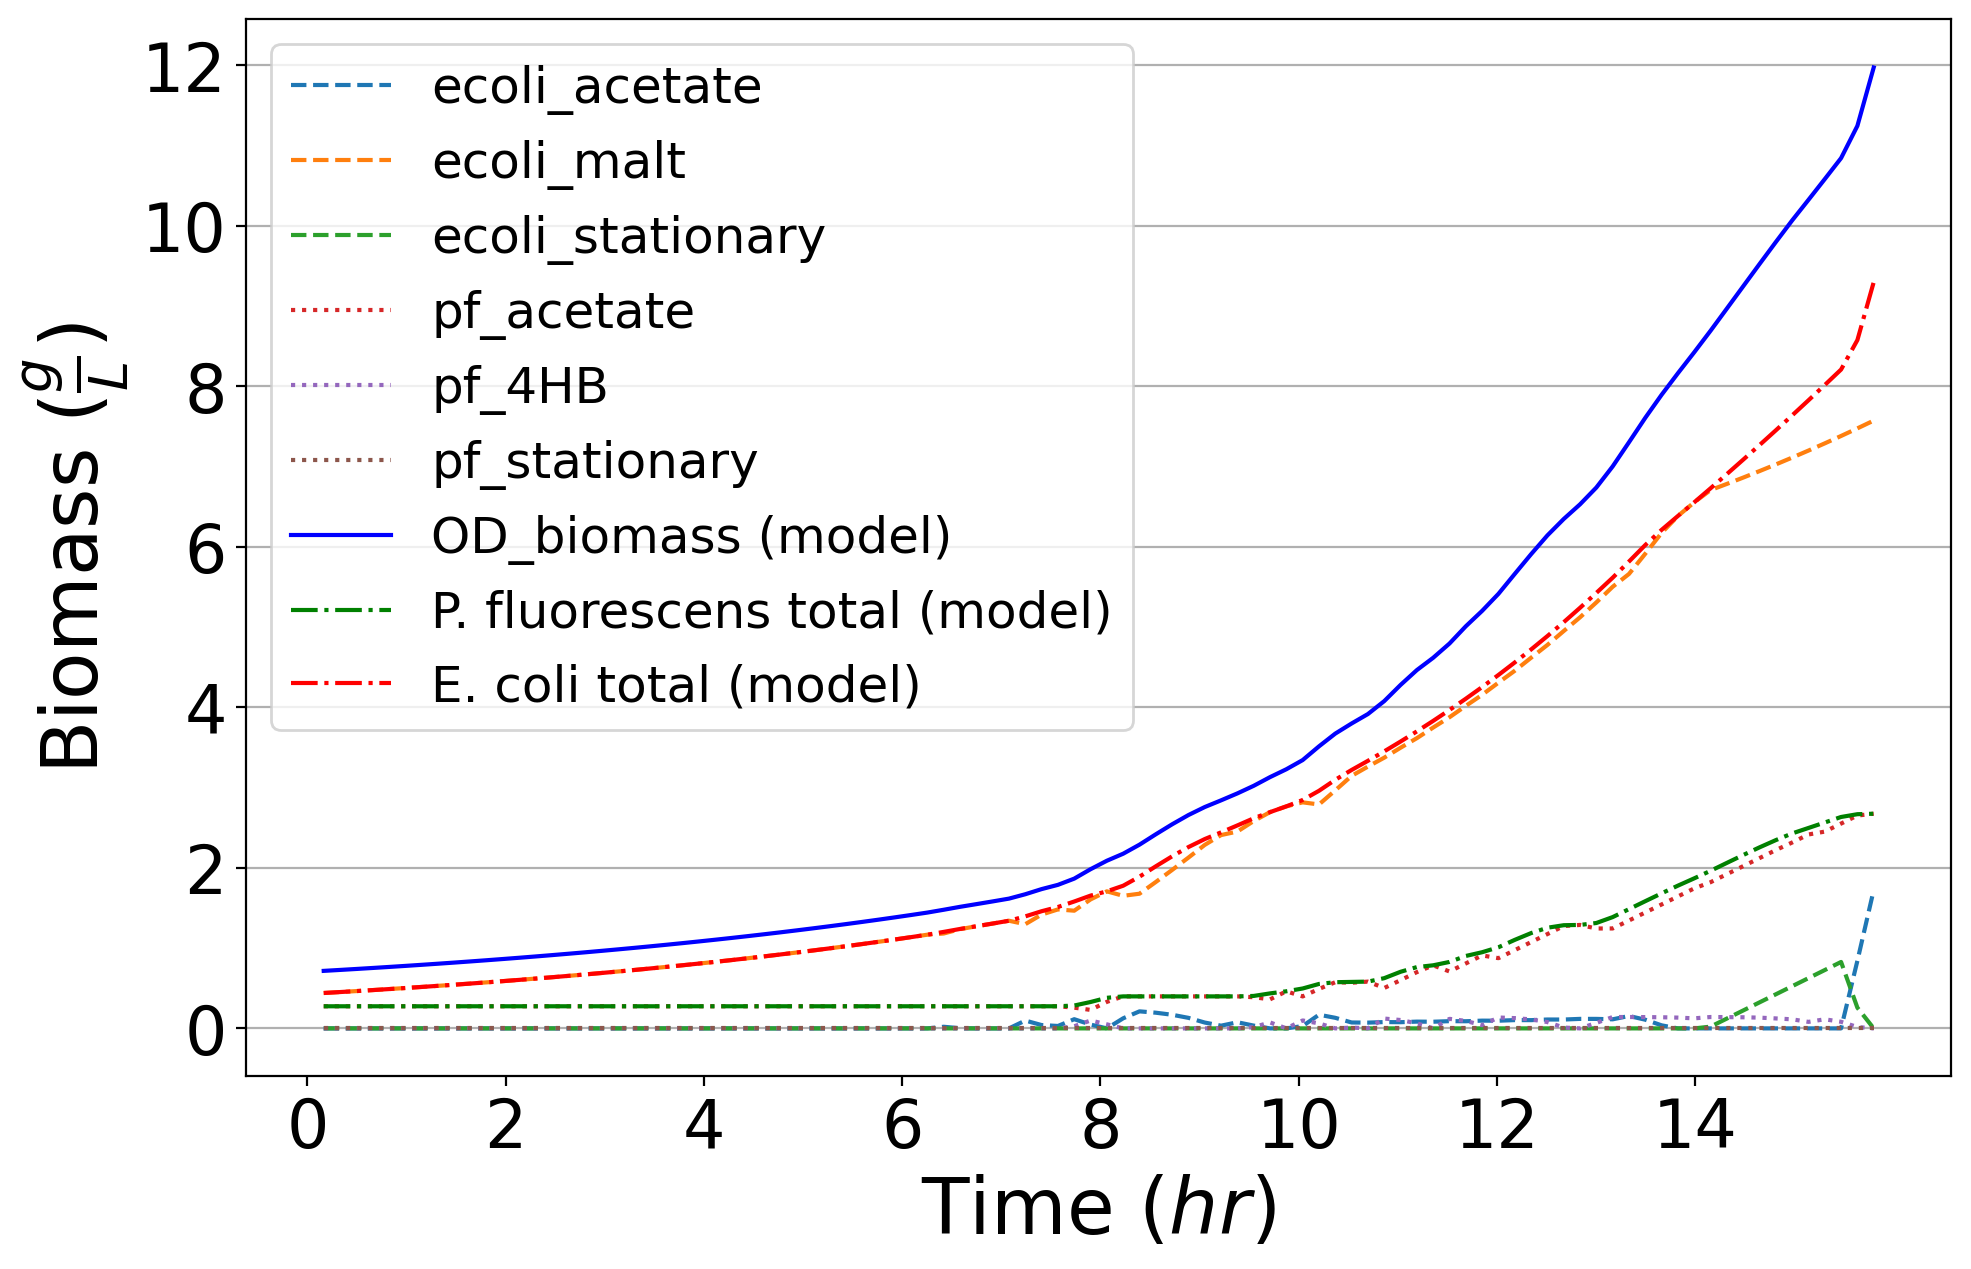

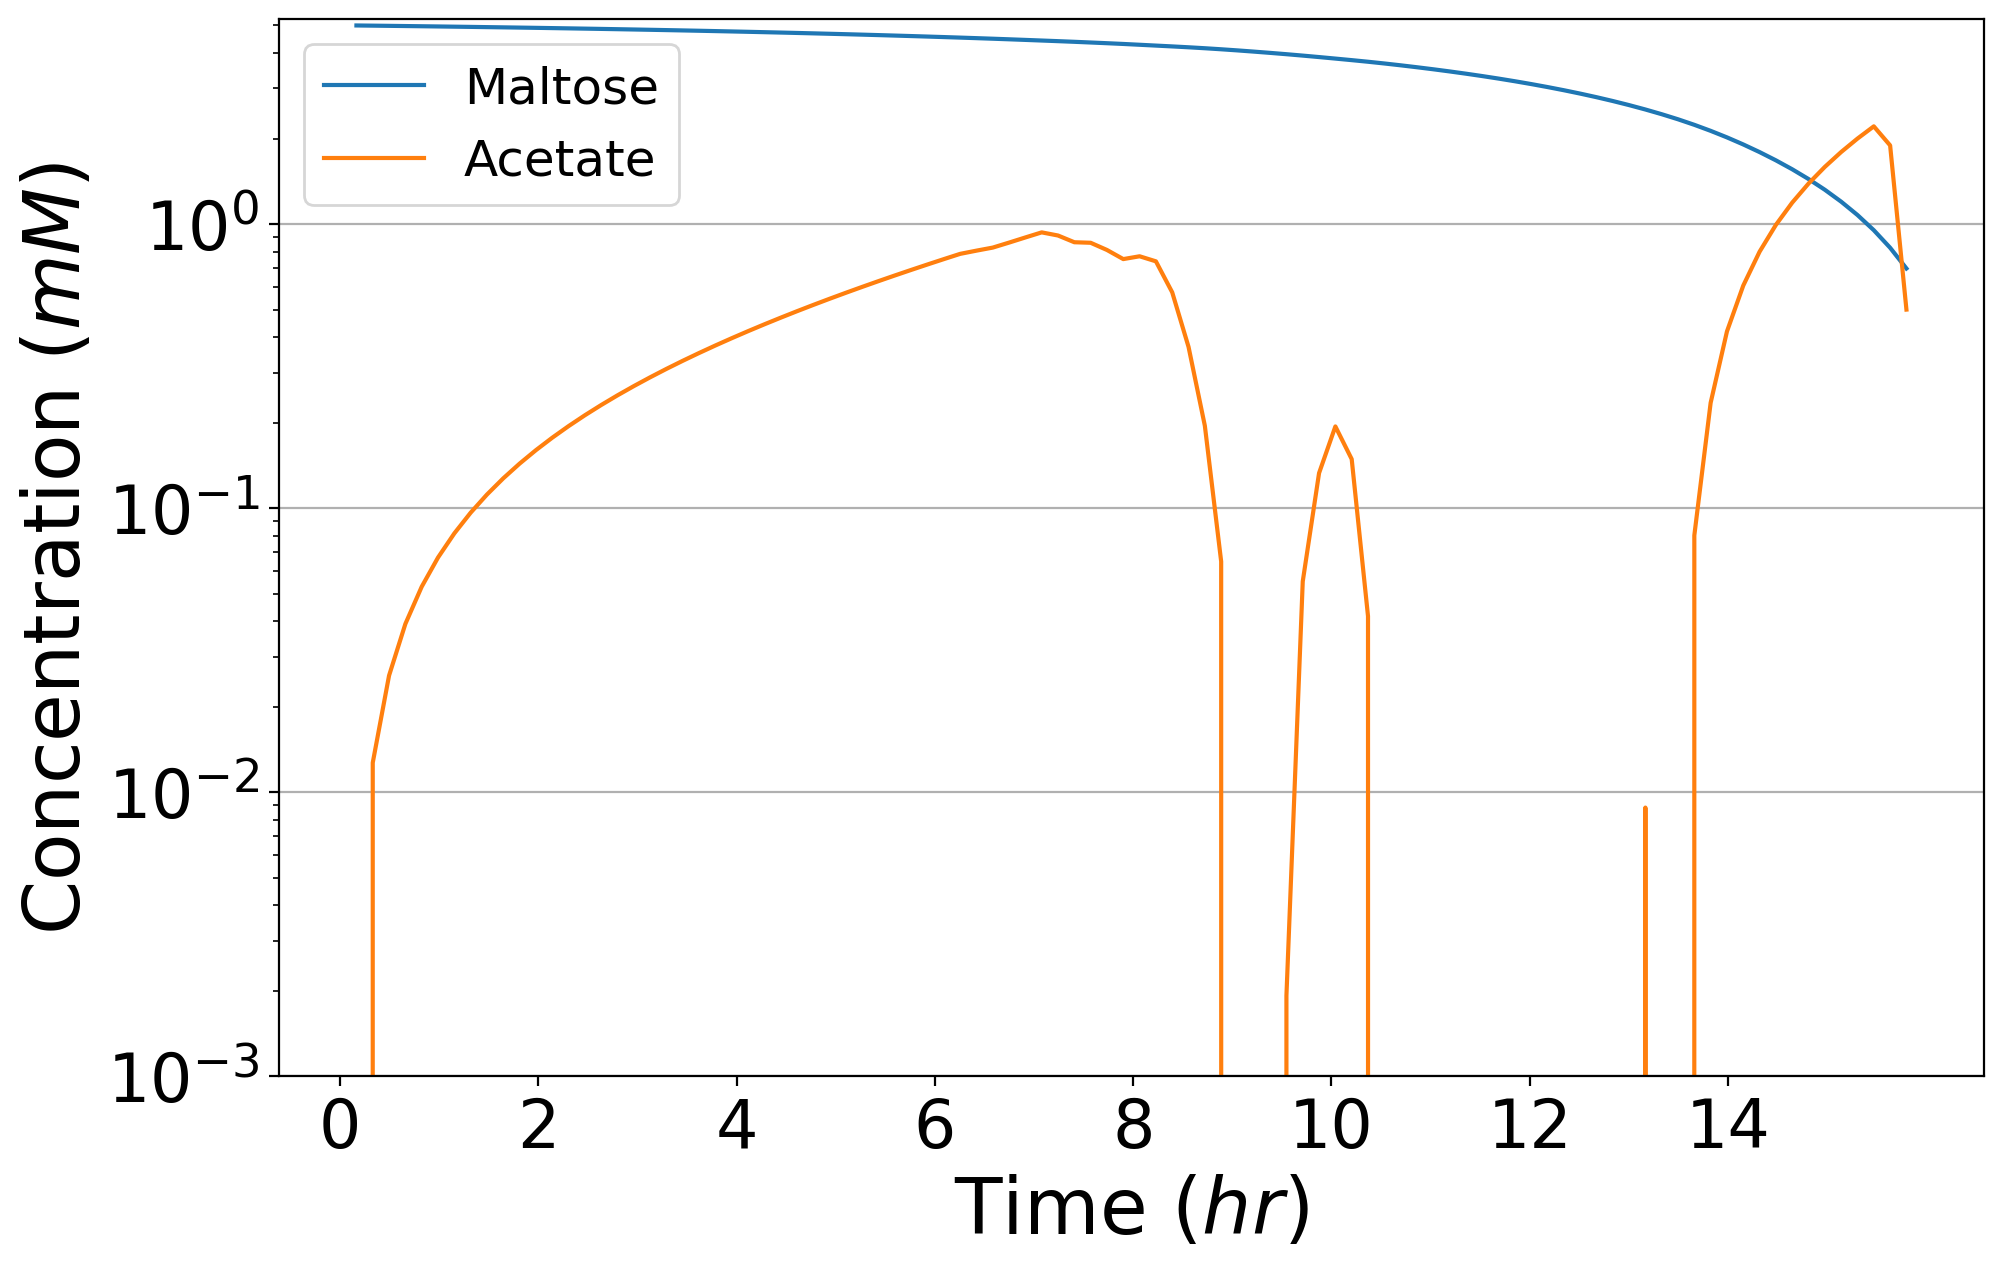

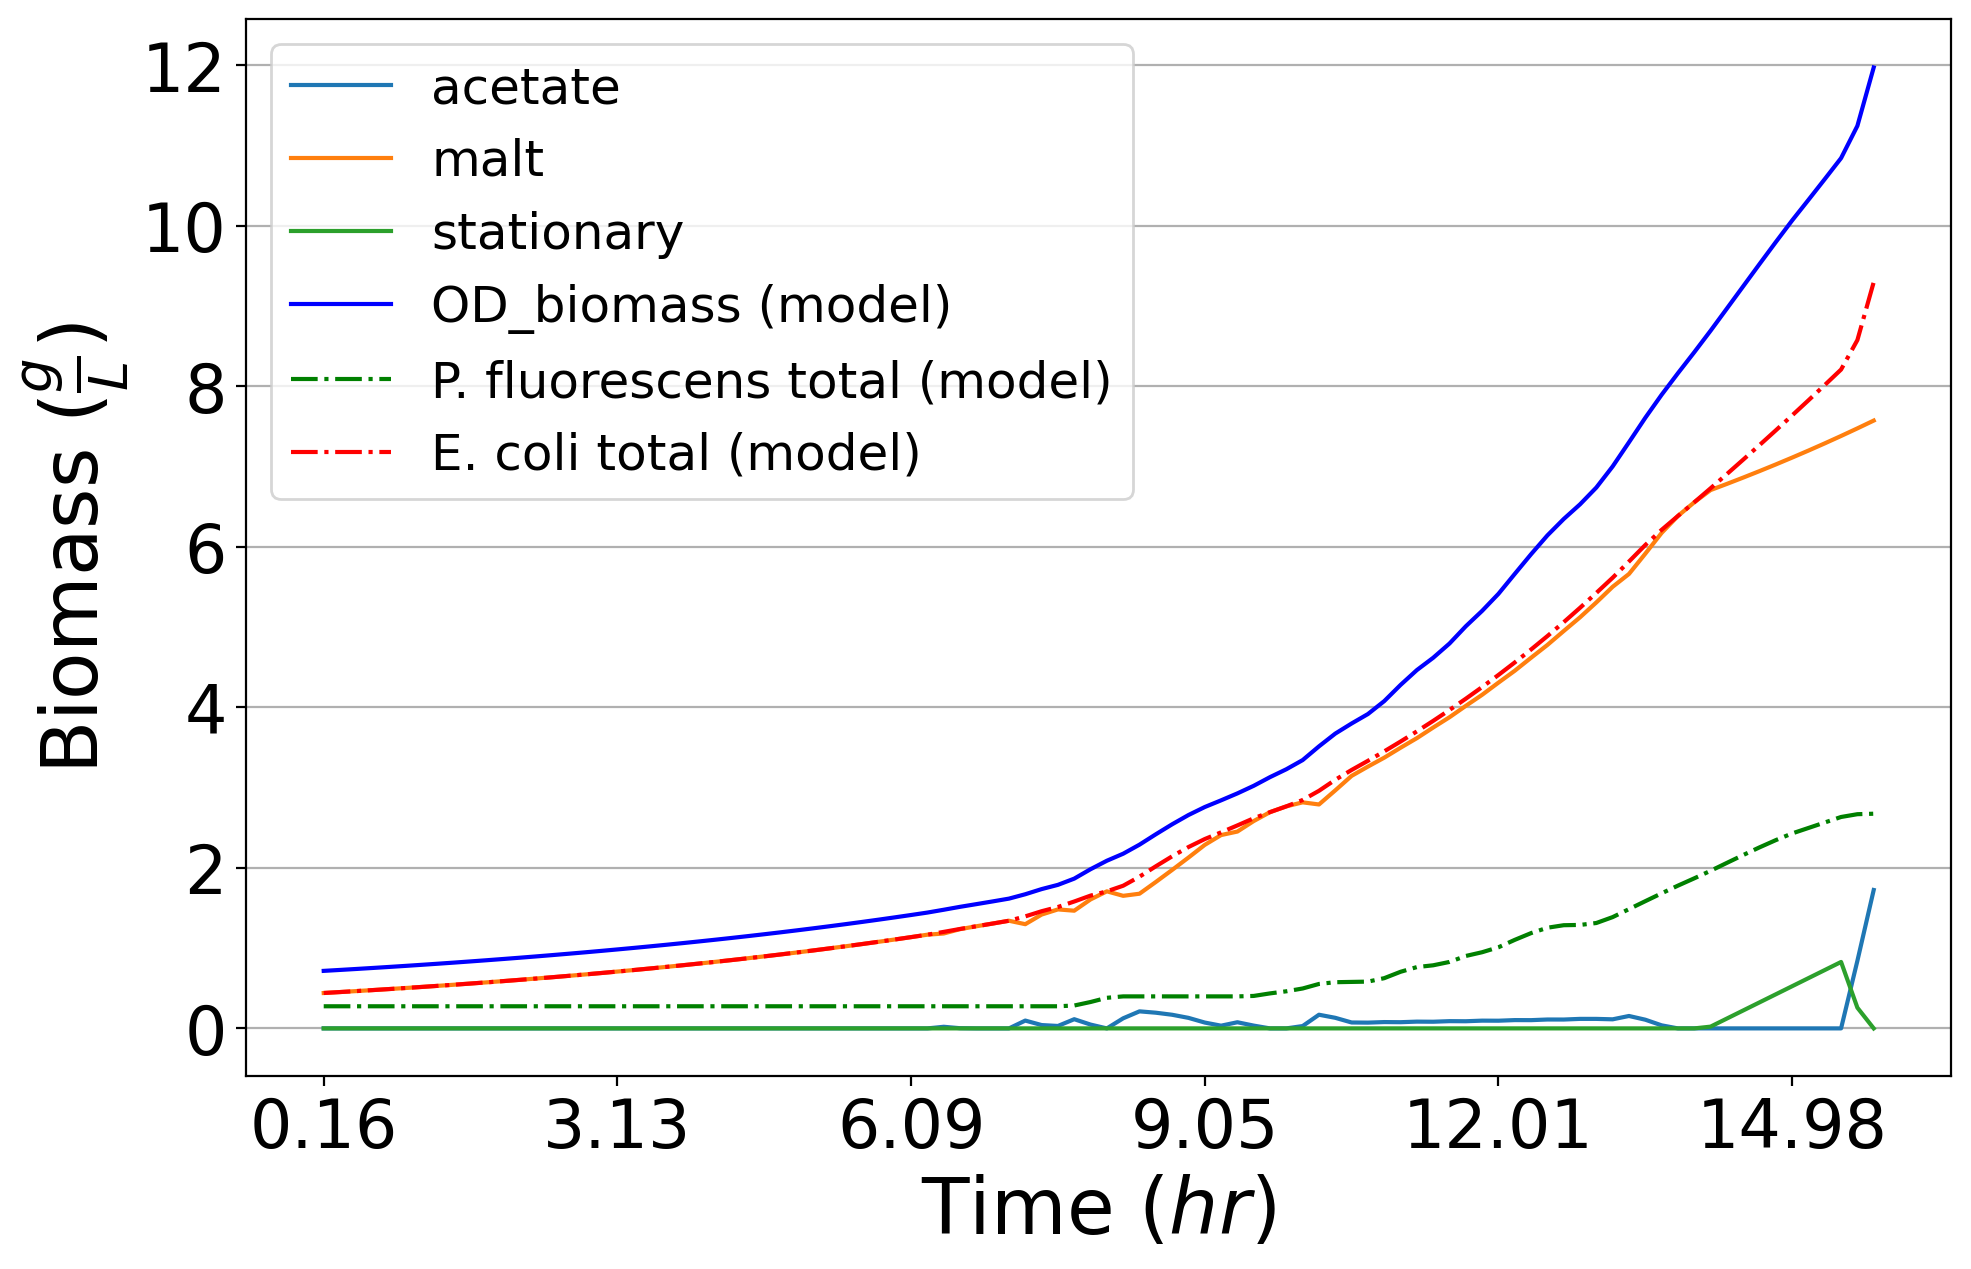

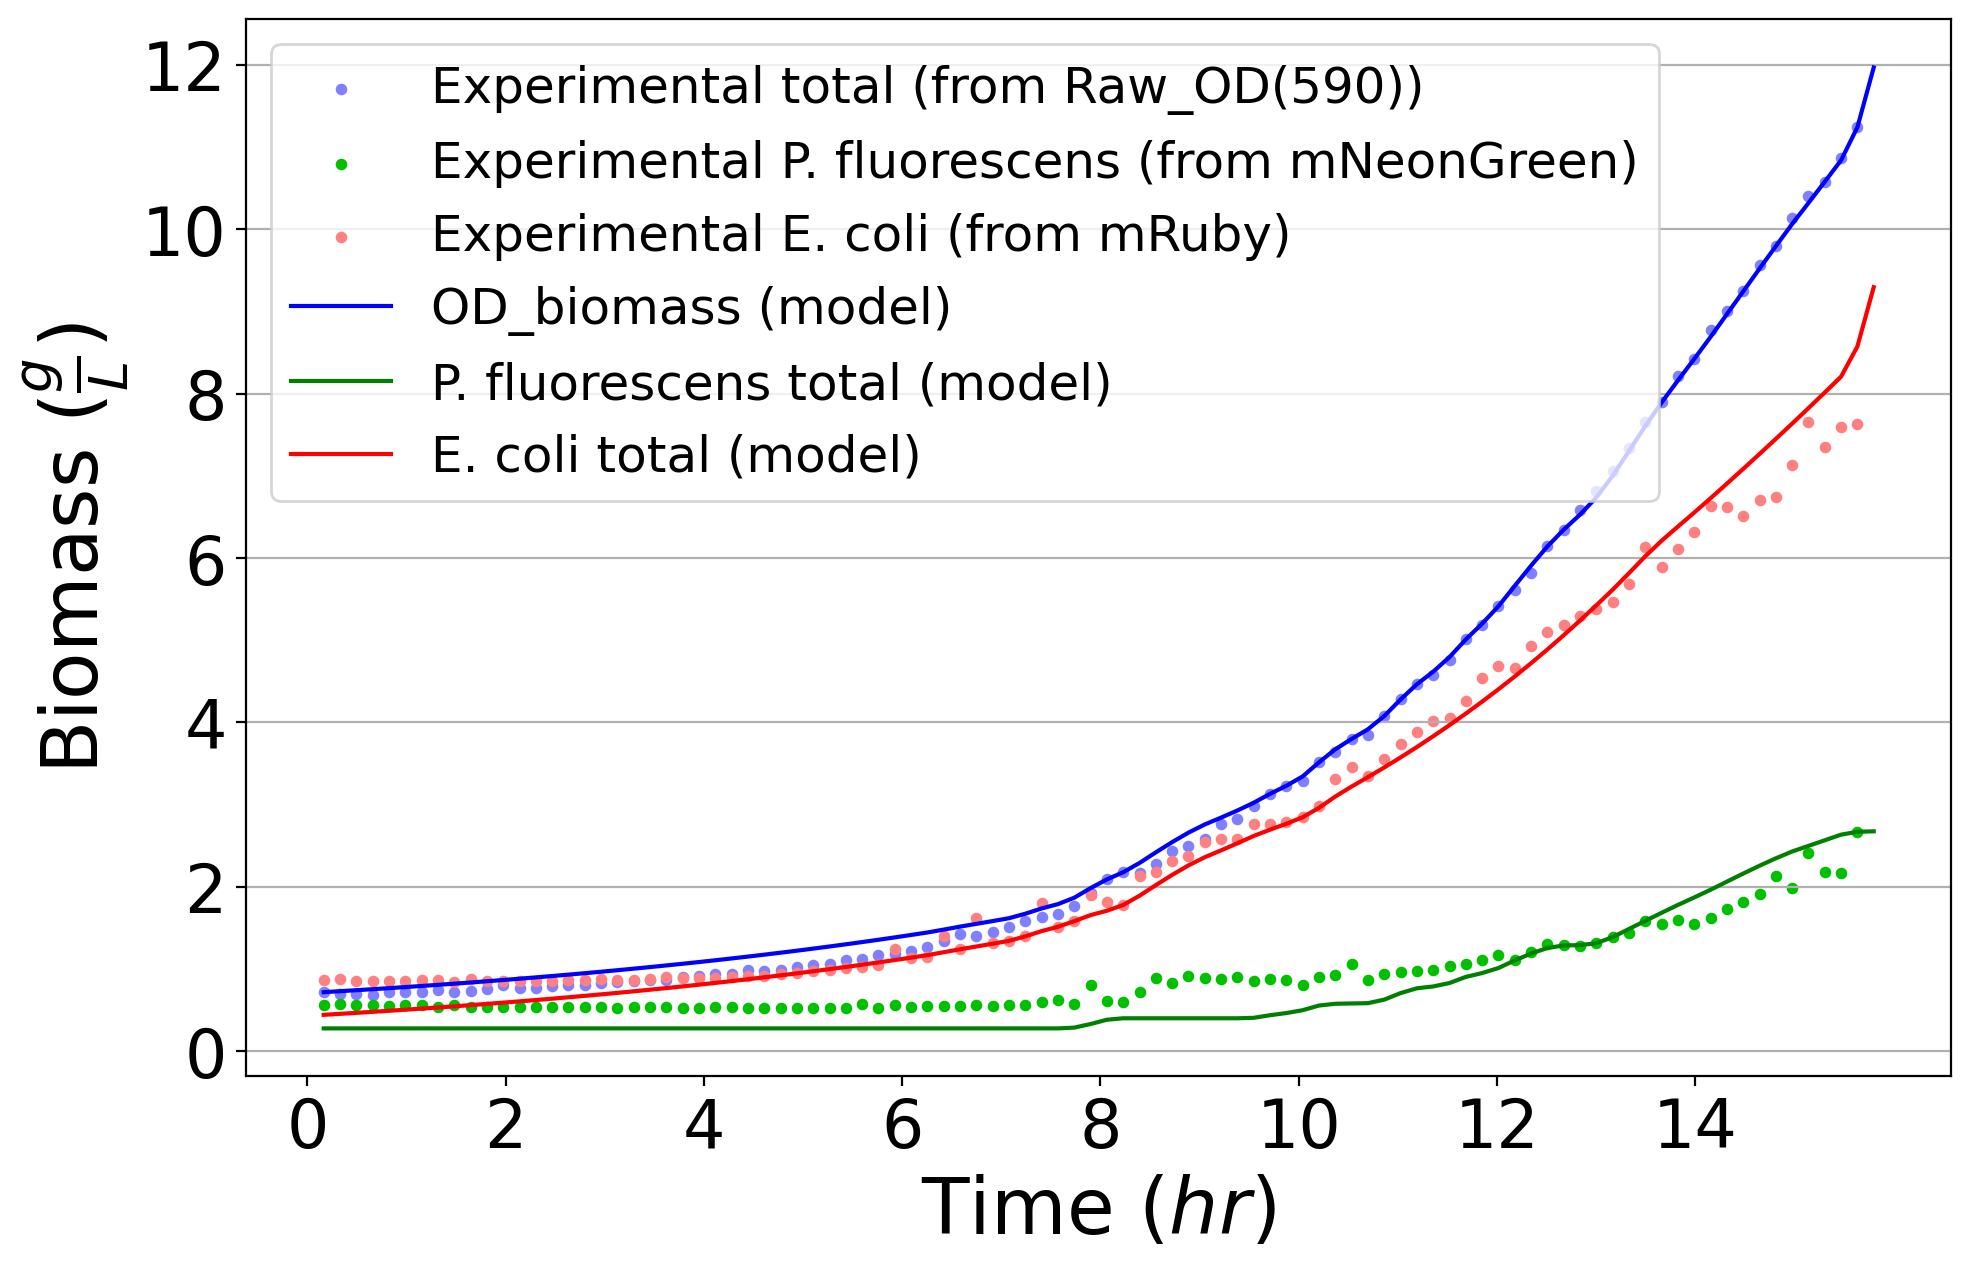

In [54]:
%run mscommfitting.py

maltose_4HB_commfit = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, growth_df, experimental_metadata)
maltose_4HB_commfit.fit_kinetics3(
    parameters={
        # 'v':.3,
        'cvmin': .1,
        'bcv': 0.0001,
        # 'diffpos': 100,
        # 'diffneg': 100,
        "stationary": 5e-3
        },
    mets_to_track = ["cpd00179","cpd00029"],
    rel_final_conc = {"cpd00179":0.2},
    zero_start=["cpd00029"],
    abs_final_conc={"cpd00029":0.5}, # metabolomics data
    graphs = update_graphs("G6", None), 
    msdb_path='../../../ModelSEED/ModelSEEDDatabase',
    export_zip_name='simple_kinetics_loop.zip', 
    requisite_biomass=requisite_biomass,
    # data_timesteps = {"A3":list(range(10))},
    publishing=True)

In [13]:
display(fluxes_df, growth_df, trial_name_conversion, requisite_biomass)

,ecoli_acetate,ecoli_malt,ecoli_stationary,pf_acetate,pf_4HB,pf_stationary
rxn,,,,,,
EX_cpd00001_e0,4.544367e+00,1.678364e+00,0,4.533296e+00,2.449417e+00,0
EX_cpd00007_e0,-2.035609e+00,-6.452599e-01,0,-2.025521e+00,-5.333032e+00,0
EX_cpd00009_e0,-7.625410e-02,-7.625410e-02,0,-7.625410e-02,-7.625410e-02,0
EX_cpd00011_e0,2.388151e+00,1.675475e-01,0,2.377641e+00,5.685222e+00,0
EX_cpd00012_e0,0.000000e+00,0.000000e+00,0,0.000000e+00,-8.351191e-15,0
EX_cpd00013_e0,-8.611666e-01,-8.611666e-01,0,-8.611666e-01,-8.611666e-01,0
EX_cpd00029_e0,-3.069851e+00,1.081686e+00,0,-3.063614e+00,0.000000e+00,0
EX_cpd00030_e0,-2.806159e-04,-2.806159e-04,0,-2.806159e-04,-2.806159e-04,0
EX_cpd00034_e0,-2.806159e-04,-2.806159e-04,0,-2.806159e-04,-2.806159e-04,0


,trial_IDs,Time (s),OD:Raw_OD(590),pf:mNeonGreen,ecoli:mRuby
short_codes,,,,,
G6,r1_ecoli_mRuby-r1_pf-5_ecoli,1.791667,0.068362,12933.0,7902.0
G6,r1_ecoli_mRuby-r1_pf-5_ecoli,597.925333,0.070993,12433.0,7538.0
G6,r1_ecoli_mRuby-r1_pf-5_ecoli,1189.803333,0.068254,12652.0,7562.0
G6,r1_ecoli_mRuby-r1_pf-5_ecoli,1782.289000,0.068291,12484.0,7395.0
G6,r1_ecoli_mRuby-r1_pf-5_ecoli,2374.768000,0.067290,12506.0,7423.0
G6,r1_ecoli_mRuby-r1_pf-5_ecoli,2967.288333,0.070729,12301.0,7340.0
G6,r1_ecoli_mRuby-r1_pf-5_ecoli,3559.622333,0.070629,12445.0,7421.0
G6,r1_ecoli_mRuby-r1_pf-5_ecoli,4152.050333,0.071764,12380.0,7456.0
G6,r1_ecoli_mRuby-r1_pf-5_ecoli,4744.461333,0.073393,12001.0,7453.0


{'B': {'2': ('G1', 'r1_pf-5_ecoli'),
  '3': ('G2', 'r1_ecoli_mRuby-r50_pf-5_ecoli'),
  '4': ('G3', 'r1_ecoli_mRuby-r20_pf-5_ecoli'),
  '5': ('G4', 'r1_ecoli_mRuby-r10_pf-5_ecoli'),
  '6': ('G5', 'r1_ecoli_mRuby-r3_pf-5_ecoli'),
  '7': ('G6', 'r1_ecoli_mRuby-r1_pf-5_ecoli'),
  '8': ('G7', 'r3_ecoli_mRuby-r1_pf-5_ecoli'),
  '9': ('G8', 'r10_ecoli_mRuby-r1_pf-5_ecoli'),
  '10': ('G9', 'r20_ecoli_mRuby-r1_pf-5_ecoli'),
  '11': ('G10', 'r1_ecoli_mRuby-5_ecoli'),
  '12': ('G11', '5_ecoli')},
 'C': {'2': ('G12', 'r1_pf-5_ecoli'),
  '3': ('G13', 'r1_ecoli_ACS-r50_pf-5_ecoli'),
  '4': ('G14', 'r1_ecoli_ACS-r20_pf-5_ecoli'),
  '5': ('G15', 'r1_ecoli_ACS-r10_pf-5_ecoli'),
  '6': ('G16', 'r1_ecoli_ACS-r3_pf-5_ecoli'),
  '7': ('G17', 'r1_ecoli_ACS-r1_pf-5_ecoli'),
  '8': ('G18', 'r3_ecoli_ACS-r1_pf-5_ecoli'),
  '9': ('G19', 'r10_ecoli_ACS-r1_pf-5_ecoli'),
  '10': ('G20', 'r20_ecoli_ACS-r1_pf-5_ecoli'),
  '11': ('G21', 'r1_ecoli_ACS-5_ecoli'),
  '12': ('G22', '5_ecoli')},
 'D': {'2': ('G23', 'r1_pf-

{'B7': -6.973933870131236}

##### Fit Kinetics2

In [7]:
%run mscommfitting.py

maltose_4HB_commfit = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, growth_df, experimental_metadata)
maltose_4HB_commfit.fit_kinetics3(
    parameters={
        'v':.3,
        'cvmin': .1,
        'bcv': 0.0001,
        'diffpos': 100,
        'diffneg': 100
        }, 
     mets_to_track = ["cpd00179","cpd00029"],
     rel_final_conc = {"cpd00179":0.2},
     zero_start=["cpd00029"],
    abs_final_conc={"cpd00029":0.5}, # metabolomics data
       graphs = update_graphs("G4", None), 
     export_zip_name='simple_kinetics_loop.zip', 
     # data_timesteps = {"A3":list(range(10))},
    msdb_path='../../../ModelSEED/ModelSEEDDatabase',
    publishing=True)

Done with concentrations and biomass loops: 0.0234375 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.0046875 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.10572916666666667 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.06901041666666667 min


NoFluxError: The simulation lacks any flux.

##### Fit Kinetics

In [12]:
%run mscommfitting.py

maltose_4HB_commfit = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, growth_df, experimental_metadata)
maltose_4HB_commfit.fit_kinetics(
    parameters={
        'v':.3,
        'cvmin': .1,
        'bcv': 0.0001,
        'diffpos': 100,
        'diffneg': 100
        }, 
     mets_to_track = ["cpd00179","cpd00029"],
     rel_final_conc = {"cpd00179":0.2},
     zero_start=["cpd00029"],
    abs_final_conc={"cpd00029":0.5}, # metabolomics data
       graphs = update_graphs("G4", None), 
     export_zip_name='simple_kinetics_loop.zip', 
     # data_timesteps = {"A3":list(range(10))},
    msdb_path='../../../ModelSEED/ModelSEEDDatabase',
    publishing=True)

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommFitting\mscommfitting.py:82: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.0026041666666666665 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08697916666666666 min
Done exporting the content: 0.027604166666666666 min
c_cpd00179_e0-G4-1
c_cpd00179_e0-G4-2
c_cpd00179_e0-G4-3
c_cpd00179_e0-G4-4
c_cpd00179_e0-G4-5
c_cpd00179_e0-G4-6
c_cpd00179_e0-G4-7
c_cpd00179_e0-G4-8
c_cpd00179_e0-G4-9
c_cpd00179_e0-G4-10
c_cpd00179_e0-G4-11
c_cpd00179_e0-G4-12
c_cpd00179_e0-G4-13
c_cpd00179_e0-G4-14
c_cpd00179_e0-G4-15
c_cpd00179_e0-G4-16
c_cpd00179_e0-G4-17
c_cpd00179_e0-G4-18
c_cpd00179_e0-G4-19
c_cpd00179_e0-G4-20
c_cpd00179_e0-G4-21
c_cpd00179_e0-G4-22
c_cpd00179_e0-G4-23
c_cpd00179_e0-G4-24
c_cpd00179_e0-G4-25
c_cpd00179_e0-G4-26
c_cpd00179_e0-G4-27
c_cpd00179_e0-G4-28
c_cpd00179_e0-G4-29
c_cpd00179_e0-G4-30
c_cpd00179_e0-G4-31
c_cpd00179_e0-G4-32
c_cpd00179_e0-G4-33
c

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommFitting\mscommfitting.py:82: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


AttributeError: 'float' object has no attribute 'items'

In [3]:
display(maltose_4HB_commfit.growth_df)

NameError: name 'maltose_4HB_commfit' is not defined

C:\Users\Andrew Freiburger\Documents\Argonne\ProjectNotebooks\CommunityModeling\CommFitting\mscommfitting.py:81: DeprecationWarning: invalid escape sequence \_
  met_id = re.sub('(\_\w\d+)', '', met)


Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.025260416666666667 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08671875 min
Done exporting the content: 0.02890625 min

Complete biomass optimization

Simple kinetics optimization, iteration: 1
Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.084375 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.026041666666666668 min
{'v_ecoli_acetate': 0.39999999999999336, 'v_ecoli_malt': 0.4000000000000001, 'v_ecoli_stationary': 0.0, 'v_pf_acetate': 0.400000000000007, 'v_pf_4HB': 0.0, 'v_pf_stationary': 0.0}

Complete growth rate optimization
Done with concentrations and biomass loops: 0.0013020833333333333 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.009375 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.07942708333333333 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.03359375 min

Complete biomass optimization
Unconverged timesteps:
{"root['G4']['b_ecoli_acetate'][21.066030162536638]": {'new_value': 0.573839144401265,
                                                       'old_value': 0.6335819220561651},
 "root['G4']['b_ecoli_acetate'][21.230608523181456]": {'new_value': 0.6129015107069147,
                                                       'old_value': 0.57324198386878},
 "root['G4']['b_ecoli_acetate'][21.395186883826273]": {'new_value': 0.5511559544171389,
                                                       'old_value': 0.5088008260305418},
 "root['G4']['b_ecoli_acetate'][21.55976524447109]": {'new_value': 0.4852136406162422,
                                                      'old_value': 0.495983570987982},
 "root['G4']['b_ecoli_acetate'][21.72434360511591]": {'new_value': 0.41478932167402255,
                                                      'old_value': 0.42629126887252305},
 "root['G4']['b_ecoli_ma

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.025520833333333333 min
{'v_ecoli_acetate': 0.3999999999999937, 'v_ecoli_malt': 0.4000000000000001, 'v_ecoli_stationary': 0.0, 'v_pf_acetate': 0.4000000000000075, 'v_pf_4HB': 0.0, 'v_pf_stationary': 0.0}

Complete growth rate optimization
Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08697916666666666 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.02734375 min

Complete biomass optimization
Unconverged timesteps:
{"root['G4']['b_ecoli_acetate'][21.066030162536638]": {'new_value': 0.633581922055949,
                                                       'old_value': 0.573839144401265},
 "root['G4']['b_ecoli_acetate'][21.230608523181456]": {'new_value': 0.5732419838685487,
                                                       'old_value': 0.6129015107069147},
 "root['G4']['b_ecoli_acetate'][21.395186883826273]": {'new_value': 0.508800826030294,
                                                       'old_value': 0.5511559544171389},
 "root['G4']['b_ecoli_acetate'][21.55976524447109]": {'new_value': 0.4959835709879824,
                                                      'old_value': 0.4852136406162422},
 "root['G4']['b_ecoli_acetate'][21.72434360511591]": {'new_value': 0.4262912688725243,
                                                      'old_value': 0.41478932167402255},
 "root['G4']['b_ecoli_ma

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.025520833333333333 min
{'v_ecoli_acetate': 0.3999999999999942, 'v_ecoli_malt': 0.4, 'v_ecoli_stationary': 0.0, 'v_pf_acetate': 0.40000000000000785, 'v_pf_4HB': 0.0, 'v_pf_stationary': 0.0}

Complete growth rate optimization
Done with concentrations and biomass loops: 0.0013020833333333333 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08776041666666666 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.03567708333333333 min

Complete biomass optimization
Unconverged timesteps:
{"root['G4']['b_ecoli_malt'][12.014220327071676]": {'new_value': 0.33744780675489927,
                                                    'old_value': 0.3102973032847095},
 "root['G4']['b_ecoli_malt'][12.178798687716494]": {'new_value': 0.3604185468396529,
                                                    'old_value': 0.33141985486179},
 "root['G4']['b_ecoli_malt'][12.343377048361312]": {'new_value': 0.38495295066581753,
                                                    'old_value': 0.35398026033061714},
 "root['G4']['b_ecoli_malt'][12.50795540900613]": {'new_value': 0.4111574599190847,
                                                   'old_value': 0.3780763972514121},
 "root['G4']['b_ecoli_malt'][12.672533769650947]": {'new_value': 0.4391457619813611,
                                                    'old_value': 0.4038128059036405},
 "root['G4']['b_ecoli_malt'][12.83711213

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.03567708333333333 min
{'v_ecoli_acetate': 0.3999999999999916, 'v_ecoli_malt': 0.39999999999999925, 'v_ecoli_stationary': 0.0, 'v_pf_acetate': 0.4000000000000129, 'v_pf_4HB': 0.0, 'v_pf_stationary': 0.0}

Complete growth rate optimization
Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08854166666666667 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.02734375 min

Complete biomass optimization
Unconverged timesteps:
{"root['G4']['b_ecoli_acetate'][21.066030162536638]": {'new_value': 0.6349742079467267,
                                                       'old_value': 0.633581922056054},
 "root['G4']['b_ecoli_acetate'][21.230608523181456]": {'new_value': 0.5990906844872608,
                                                       'old_value': 0.5732419838686609},
 "root['G4']['b_ecoli_acetate'][21.395186883826273]": {'new_value': 0.5364064260113698,
                                                       'old_value': 0.5088008260304139},
 "root['G4']['b_ecoli_acetate'][21.55976524447109]": {'new_value': 0.46946160777384727,
                                                      'old_value': 0.49598357098798257},
 "root['G4']['b_ecoli_acetate'][21.72434360511591]": {'new_value': 0.39796664559640405,
                                                      'old_value': 0.42629126887252405},
 "root['G4']['b_eco

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.02578125 min
{'v_ecoli_acetate': 0.3999999999999901, 'v_ecoli_malt': 0.39999999999999913, 'v_ecoli_stationary': 0.0, 'v_pf_acetate': 0.4000000000000133, 'v_pf_4HB': 0.0, 'v_pf_stationary': 0.0}

Complete growth rate optimization
Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08697916666666666 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.026822916666666665 min

Complete biomass optimization
Unconverged timesteps:
{"root['G4']['b_ecoli_acetate'][21.230608523181456]": {'new_value': 0.6103757860895155,
                                                       'old_value': 0.5990906844872608},
 "root['G4']['b_ecoli_acetate'][21.395186883826273]": {'new_value': 0.5484585598951176,
                                                       'old_value': 0.5364064260113698},
 "root['G4']['b_ecoli_acetate'][21.55976524447109]": {'new_value': 0.48233290803070666,
                                                      'old_value': 0.46946160777384727},
 "root['G4']['b_ecoli_acetate'][21.72434360511591]": {'new_value': 0.411712789797941,
                                                      'old_value': 0.39796664559640405},
 "root['G4']['b_ecoli_acetate'][21.888921965760726]": {'new_value': 0.33629272271964467,
                                                       'old_value': 0.35186208025145577},
 "root['

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.026041666666666668 min
{'v_ecoli_acetate': 0.3999999999999885, 'v_ecoli_malt': 0.3999999999999989, 'v_ecoli_stationary': 0.0, 'v_pf_acetate': 0.40000000000001373, 'v_pf_4HB': 0.0, 'v_pf_stationary': 0.0}

Complete growth rate optimization
Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08802083333333334 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.026822916666666665 min

Complete biomass optimization
Unconverged timesteps:
{"root['G4']['b_ecoli_acetate'][21.230608523181456]": {'new_value': 0.5902627591112317,
                                                       'old_value': 0.6103757860895155},
 "root['G4']['b_ecoli_acetate'][21.395186883826273]": {'new_value': 0.5269784791219605,
                                                       'old_value': 0.5484585598951176},
 "root['G4']['b_ecoli_acetate'][21.55976524447109]": {'new_value': 0.45939285676345964,
                                                      'old_value': 0.48233290803070666},
 "root['G4']['b_ecoli_acetate'][21.72434360511591]": {'new_value': 0.4262912688725295,
                                                      'old_value': 0.411712789797941},
 "root['G4']['b_ecoli_acetate'][21.888921965760726]": {'new_value': 0.35186208025145704,
                                                       'old_value': 0.33629272271964467},
 "root['G

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.0328125 min
{'v_ecoli_acetate': 0.3999999999999874, 'v_ecoli_malt': 0.39999999999999875, 'v_ecoli_stationary': 0.0, 'v_pf_acetate': 0.400000000000016, 'v_pf_4HB': 0.0, 'v_pf_stationary': 0.0}

Complete growth rate optimization
Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08828125 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.027083333333333334 min

Complete biomass optimization
Unconverged timesteps:
{"root['G4']['b_ecoli_acetate'][21.230608523181456]": {'new_value': 0.6103757860895682,
                                                       'old_value': 0.5902627591112317},
 "root['G4']['b_ecoli_acetate'][21.395186883826273]": {'new_value': 0.5484585598951738,
                                                       'old_value': 0.5269784791219605},
 "root['G4']['b_ecoli_acetate'][21.55976524447109]": {'new_value': 0.48233290803076656,
                                                      'old_value': 0.45939285676345964},
 "root['G4']['b_ecoli_acetate'][21.72434360511591]": {'new_value': 0.4117127897980048,
                                                      'old_value': 0.4262912688725295},
 "root['G4']['b_ecoli_acetate'][21.888921965760726]": {'new_value': 0.33629272271971483,
                                                       'old_value': 0.35186208025145704},
 "root['

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.026302083333333334 min
{'v_ecoli_acetate': 0.39999999999998564, 'v_ecoli_malt': 0.39999999999999825, 'v_ecoli_stationary': 0.0, 'v_pf_acetate': 0.4000000000000154, 'v_pf_4HB': 0.0, 'v_pf_stationary': 0.0}

Complete growth rate optimization
Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08776041666666666 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.027864583333333335 min

Complete biomass optimization
Unconverged timesteps:
{"root['G4']['b_ecoli_acetate'][21.230608523181456]": {'new_value': 0.5990906844873094,
                                                       'old_value': 0.6103757860895682},
 "root['G4']['b_ecoli_acetate'][21.395186883826273]": {'new_value': 0.536406426011421,
                                                       'old_value': 0.5484585598951738},
 "root['G4']['b_ecoli_acetate'][21.55976524447109]": {'new_value': 0.4694616077739016,
                                                      'old_value': 0.48233290803076656},
 "root['G4']['b_ecoli_acetate'][21.72434360511591]": {'new_value': 0.39796664559646155,
                                                      'old_value': 0.4117127897980048},
 "root['G4']['b_ecoli_acetate'][21.888921965760726]": {'new_value': 0.3518620802514631,
                                                       'old_value': 0.33629272271971483},
 "root['G4

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.026041666666666668 min
{'v_ecoli_acetate': 0.3999999999999459, 'v_ecoli_malt': 0.3999999999999987, 'v_ecoli_stationary': 0.0, 'v_pf_acetate': 0.400000000000056, 'v_pf_4HB': 0.0, 'v_pf_stationary': 0.0}

Complete growth rate optimization
Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.08828125 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.02734375 min

Complete biomass optimization
Unconverged timesteps:
{"root['G4']['b_ecoli_acetate'][21.230608523181456]": {'new_value': 0.6043722109883676,
                                                       'old_value': 0.5990906844873094},
 "root['G4']['b_ecoli_acetate'][21.395186883826273]": {'new_value': 0.5420469303457865,
                                                       'old_value': 0.536406426011421},
 "root['G4']['b_ecoli_acetate'][21.55976524447109]": {'new_value': 0.4754854891535796,
                                                      'old_value': 0.4694616077739016},
 "root['G4']['b_ecoli_acetate'][21.72434360511591]": {'new_value': 0.40439996161314373,
                                                      'old_value': 0.39796664559646155},
 "root['G4']['b_ecoli_acetate'][21.888921965760726]": {'new_value': 0.32848285201946226,
                                                       'old_value': 0.3518620802514631},
 "root['G4']['b_ecol

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.0265625 min
{'v_ecoli_acetate': 0.399999999999946, 'v_ecoli_malt': 0.3999999999999989, 'v_ecoli_stationary': 0.0, 'v_pf_acetate': 0.4000000000000559, 'v_pf_4HB': 0.0, 'v_pf_stationary': 0.0}

Complete growth rate optimization
Done with concentrations and biomass loops: 0.0015625 min
Done with DCC loop: 0.00026041666666666666 min
Done with the DBC & diffc loop: 0.003125 min
Solver: <class 'optlang.glpk_interface.Model'>
Done with loading the variables, constraints, and objective: 0.0890625 min


C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'parameters.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\zipfile.py:1514: UserWarning: Duplicate name: 'CommPhitting.json'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Done exporting the content: 0.02734375 min

Complete biomass optimization
Unconverged timesteps:
{"root['G4']['b_ecoli_acetate'][21.230608523181456]": {'new_value': 0.5902627591112792,
                                                       'old_value': 0.6043722109883676},
 "root['G4']['b_ecoli_acetate'][21.395186883826273]": {'new_value': 0.5269784791220073,
                                                       'old_value': 0.5420469303457865},
 "root['G4']['b_ecoli_acetate'][21.55976524447109]": {'new_value': 0.45939285676350095,
                                                      'old_value': 0.4754854891535796},
 "root['G4']['b_ecoli_acetate'][21.72434360511591]": {'new_value': 0.4262912688725321,
                                                      'old_value': 0.40439996161314373},
 "root['G4']['b_ecoli_acetate'][21.888921965760726]": {'new_value': 0.3518620802514617,
                                                       'old_value': 0.32848285201946226},
 "root['G4']['b_eco

{'v_ecoli_acetate': 0.399999999999946,
 'v_ecoli_malt': 0.3999999999999989,
 'v_ecoli_stationary': 0.0,
 'v_pf_acetate': 0.4000000000000559,
 'v_pf_4HB': 0.0,
 'v_pf_stationary': 0.0}

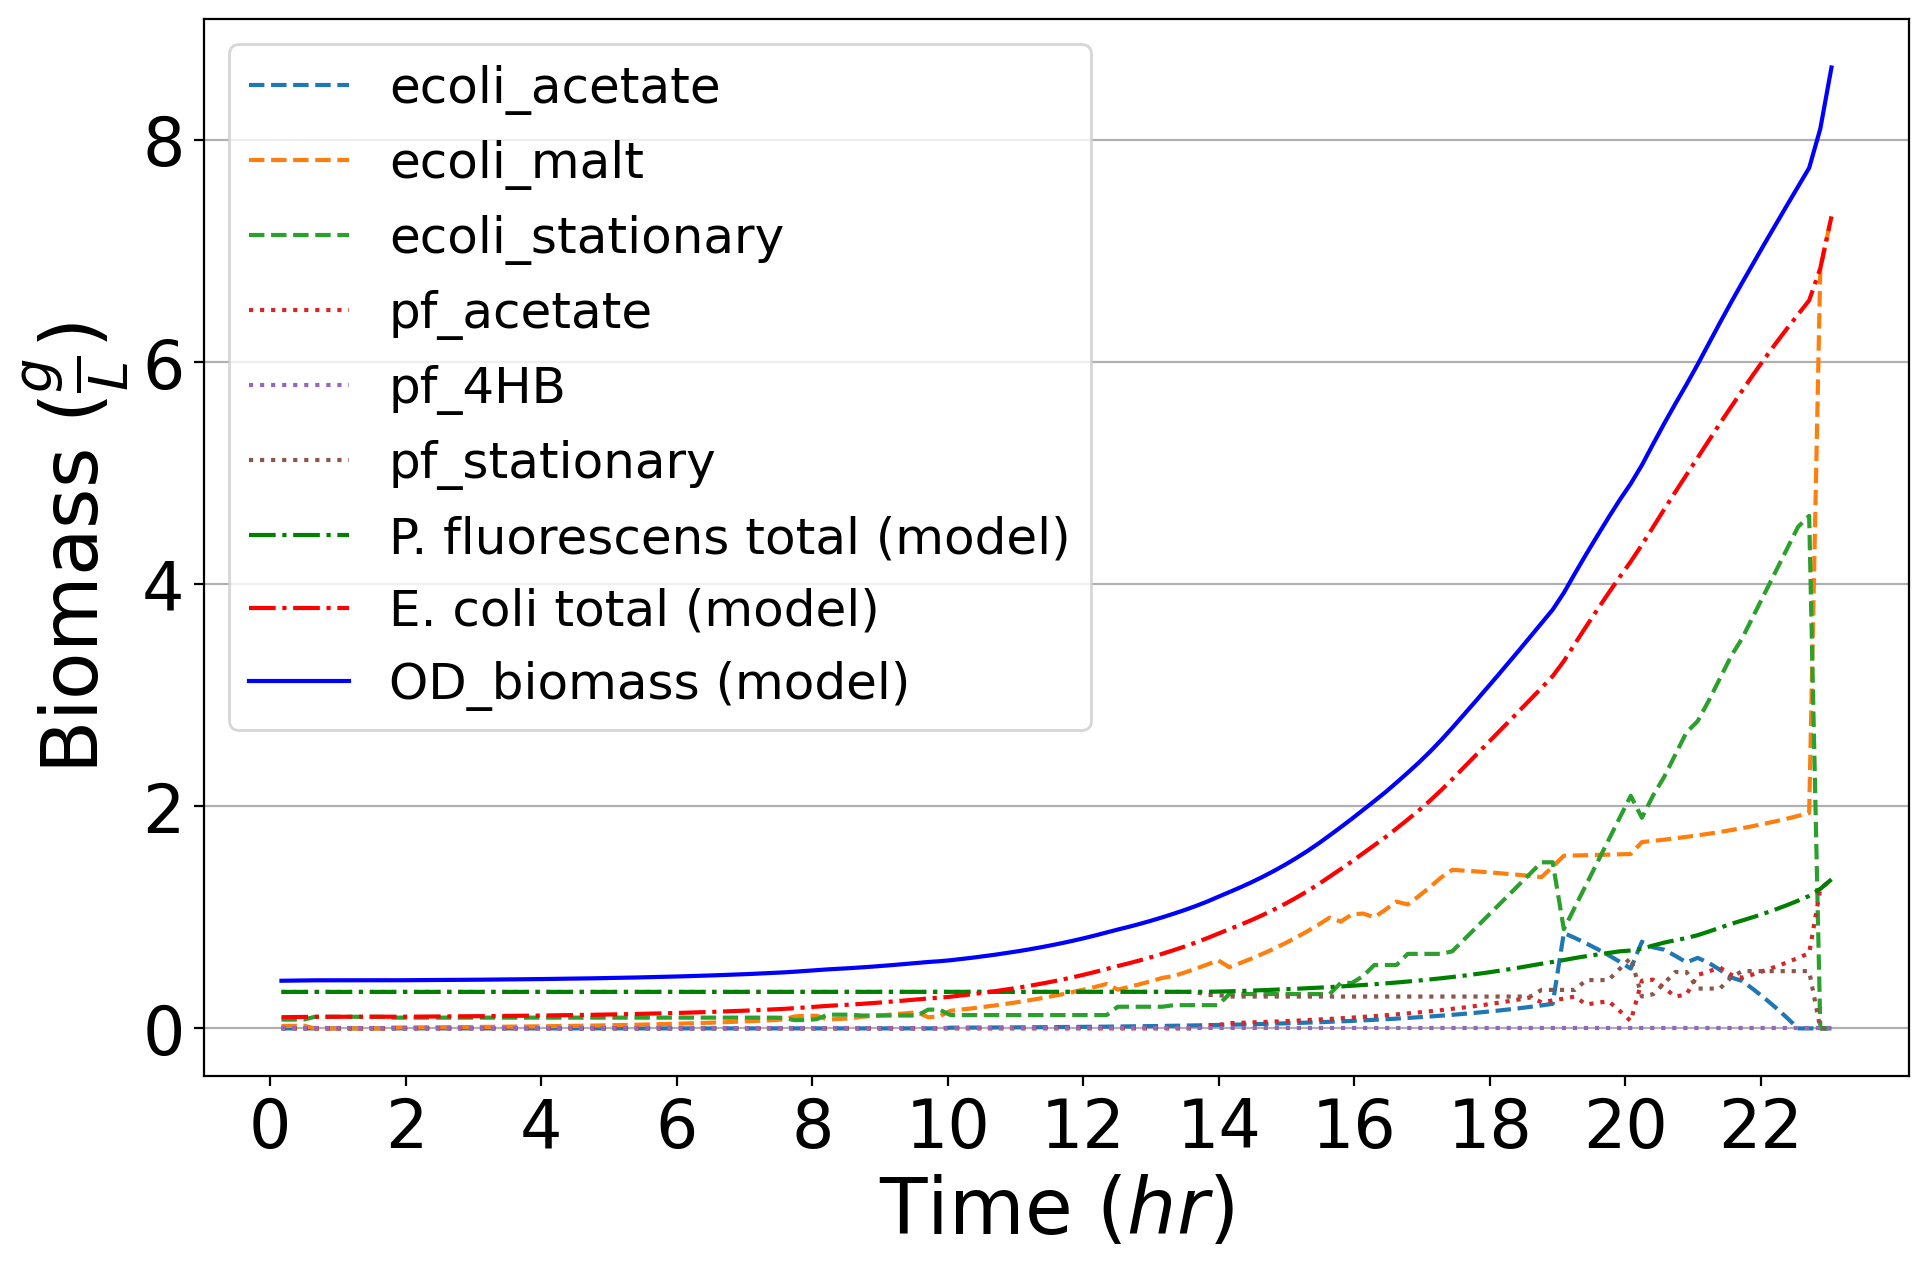

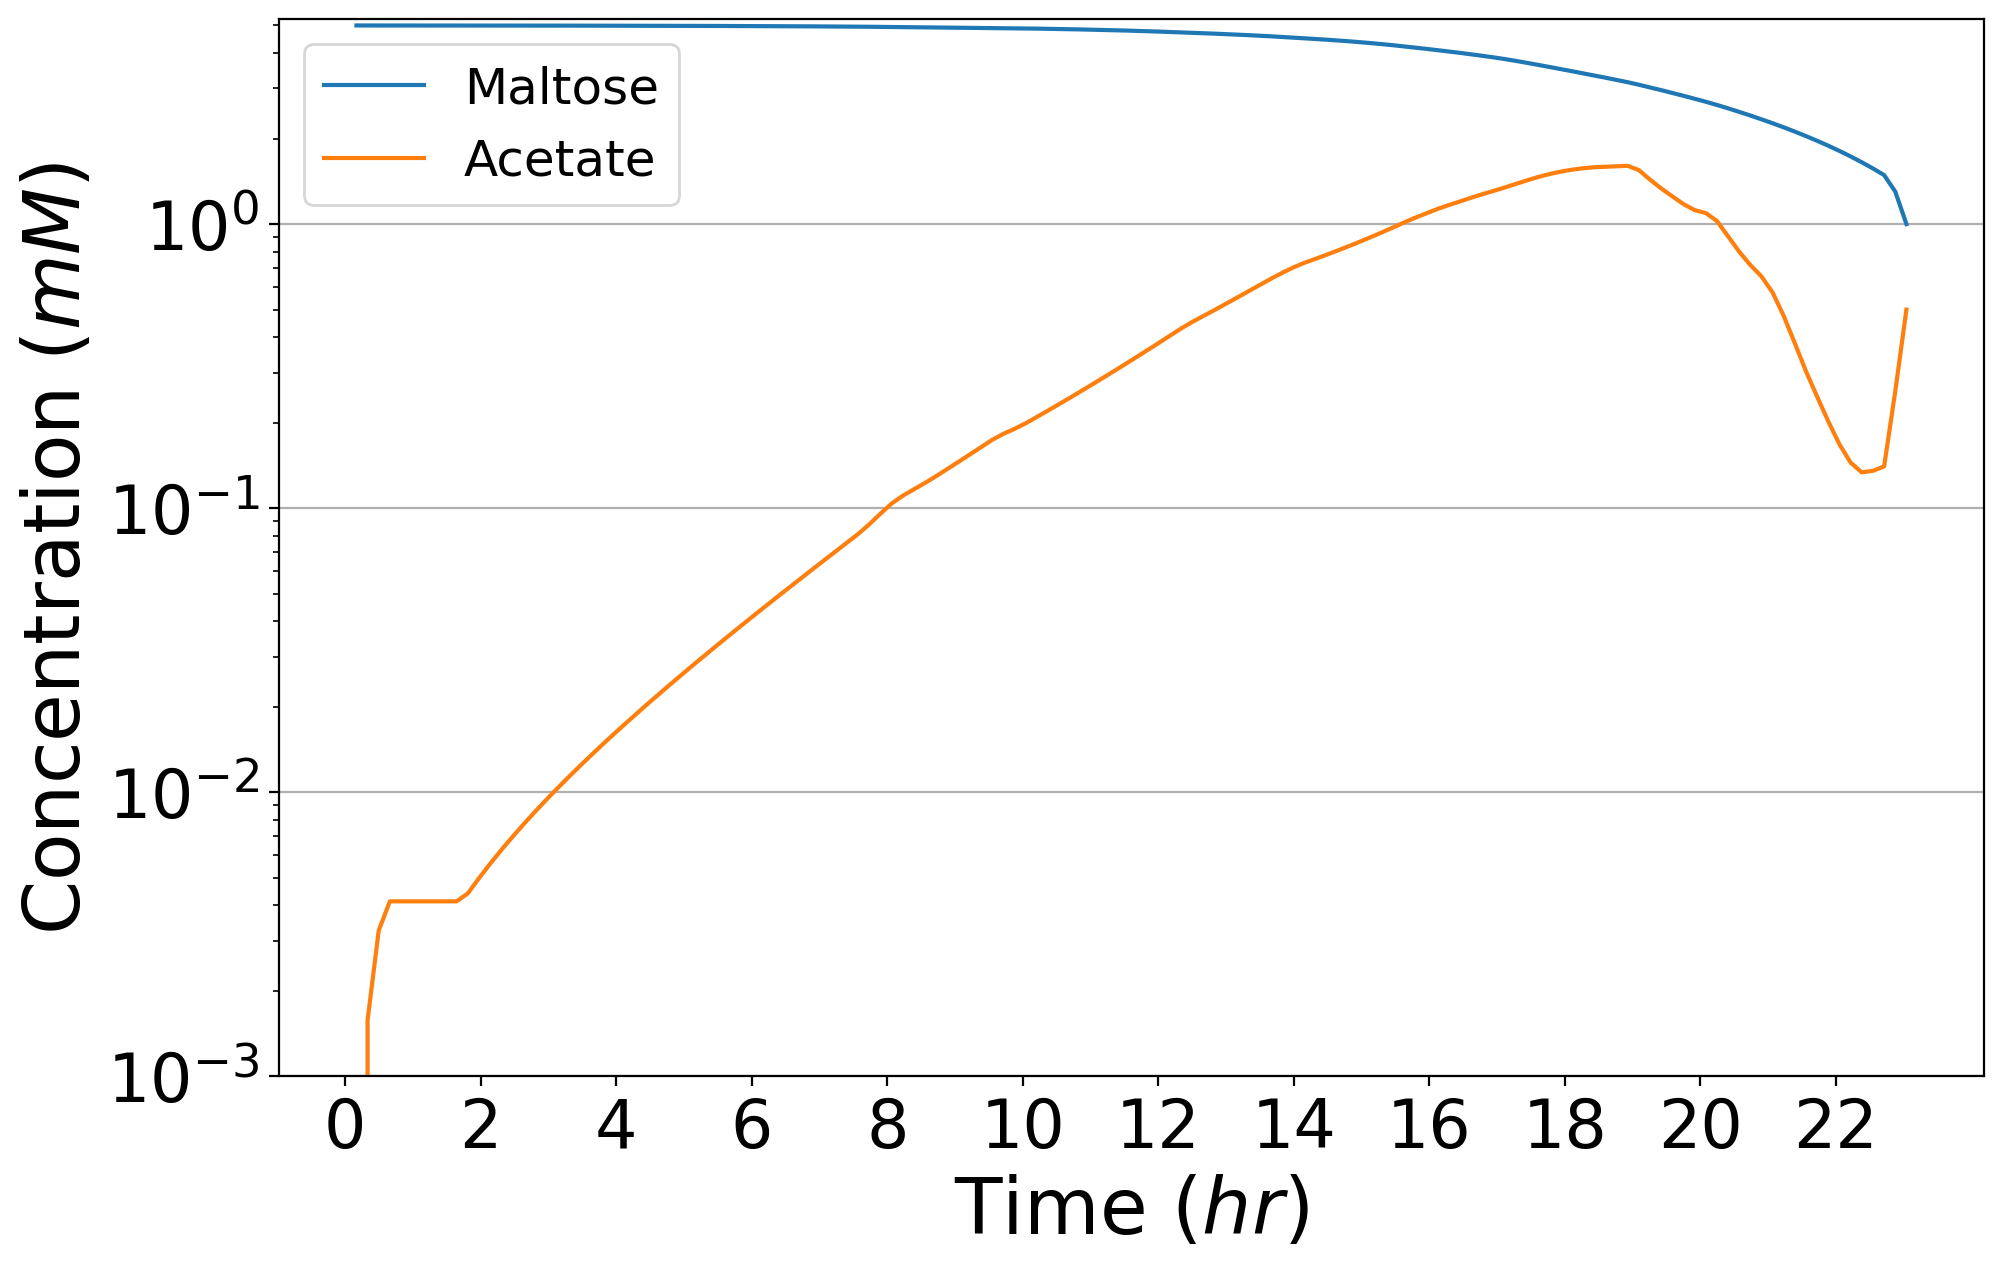

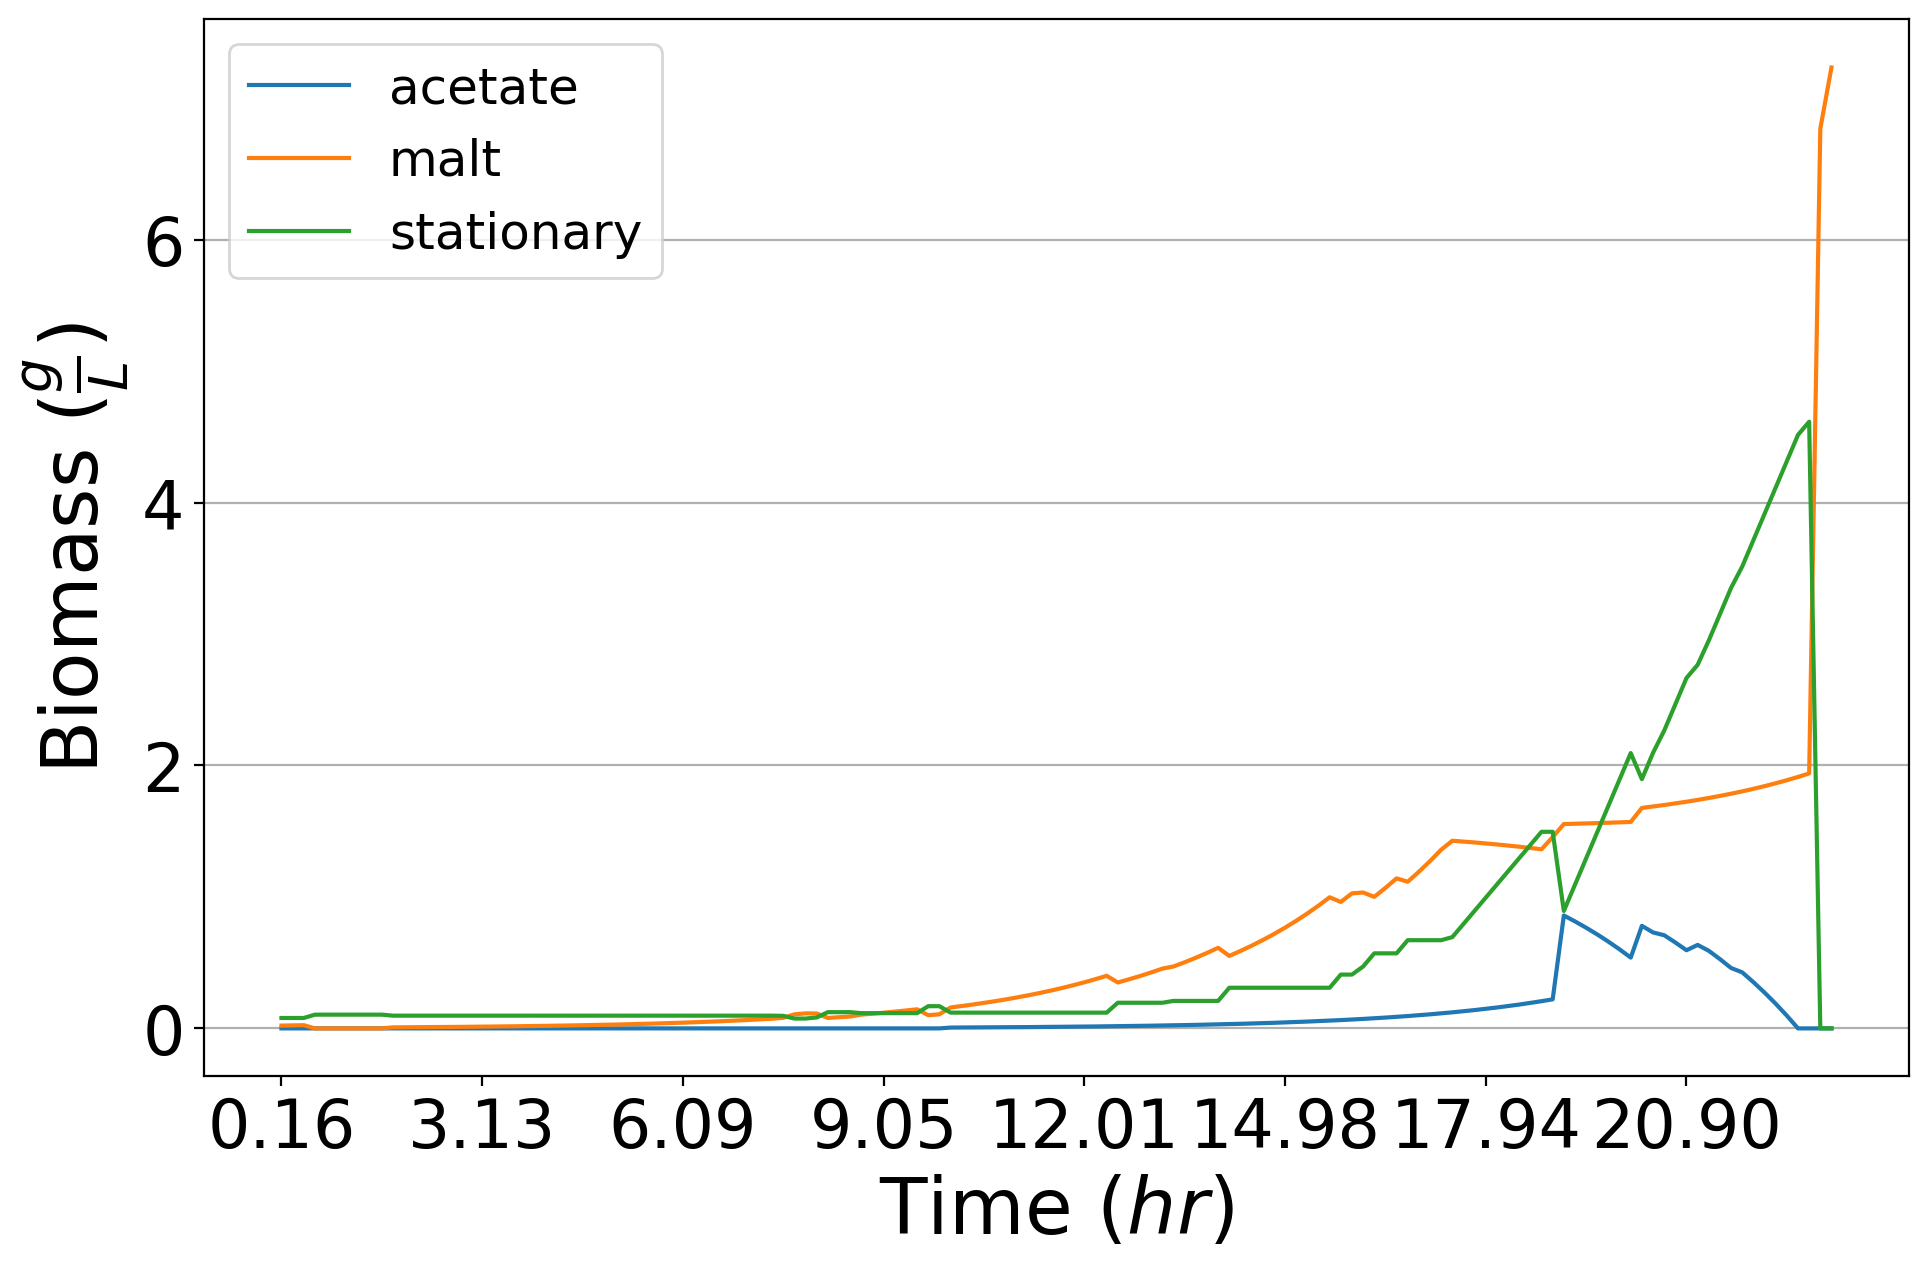

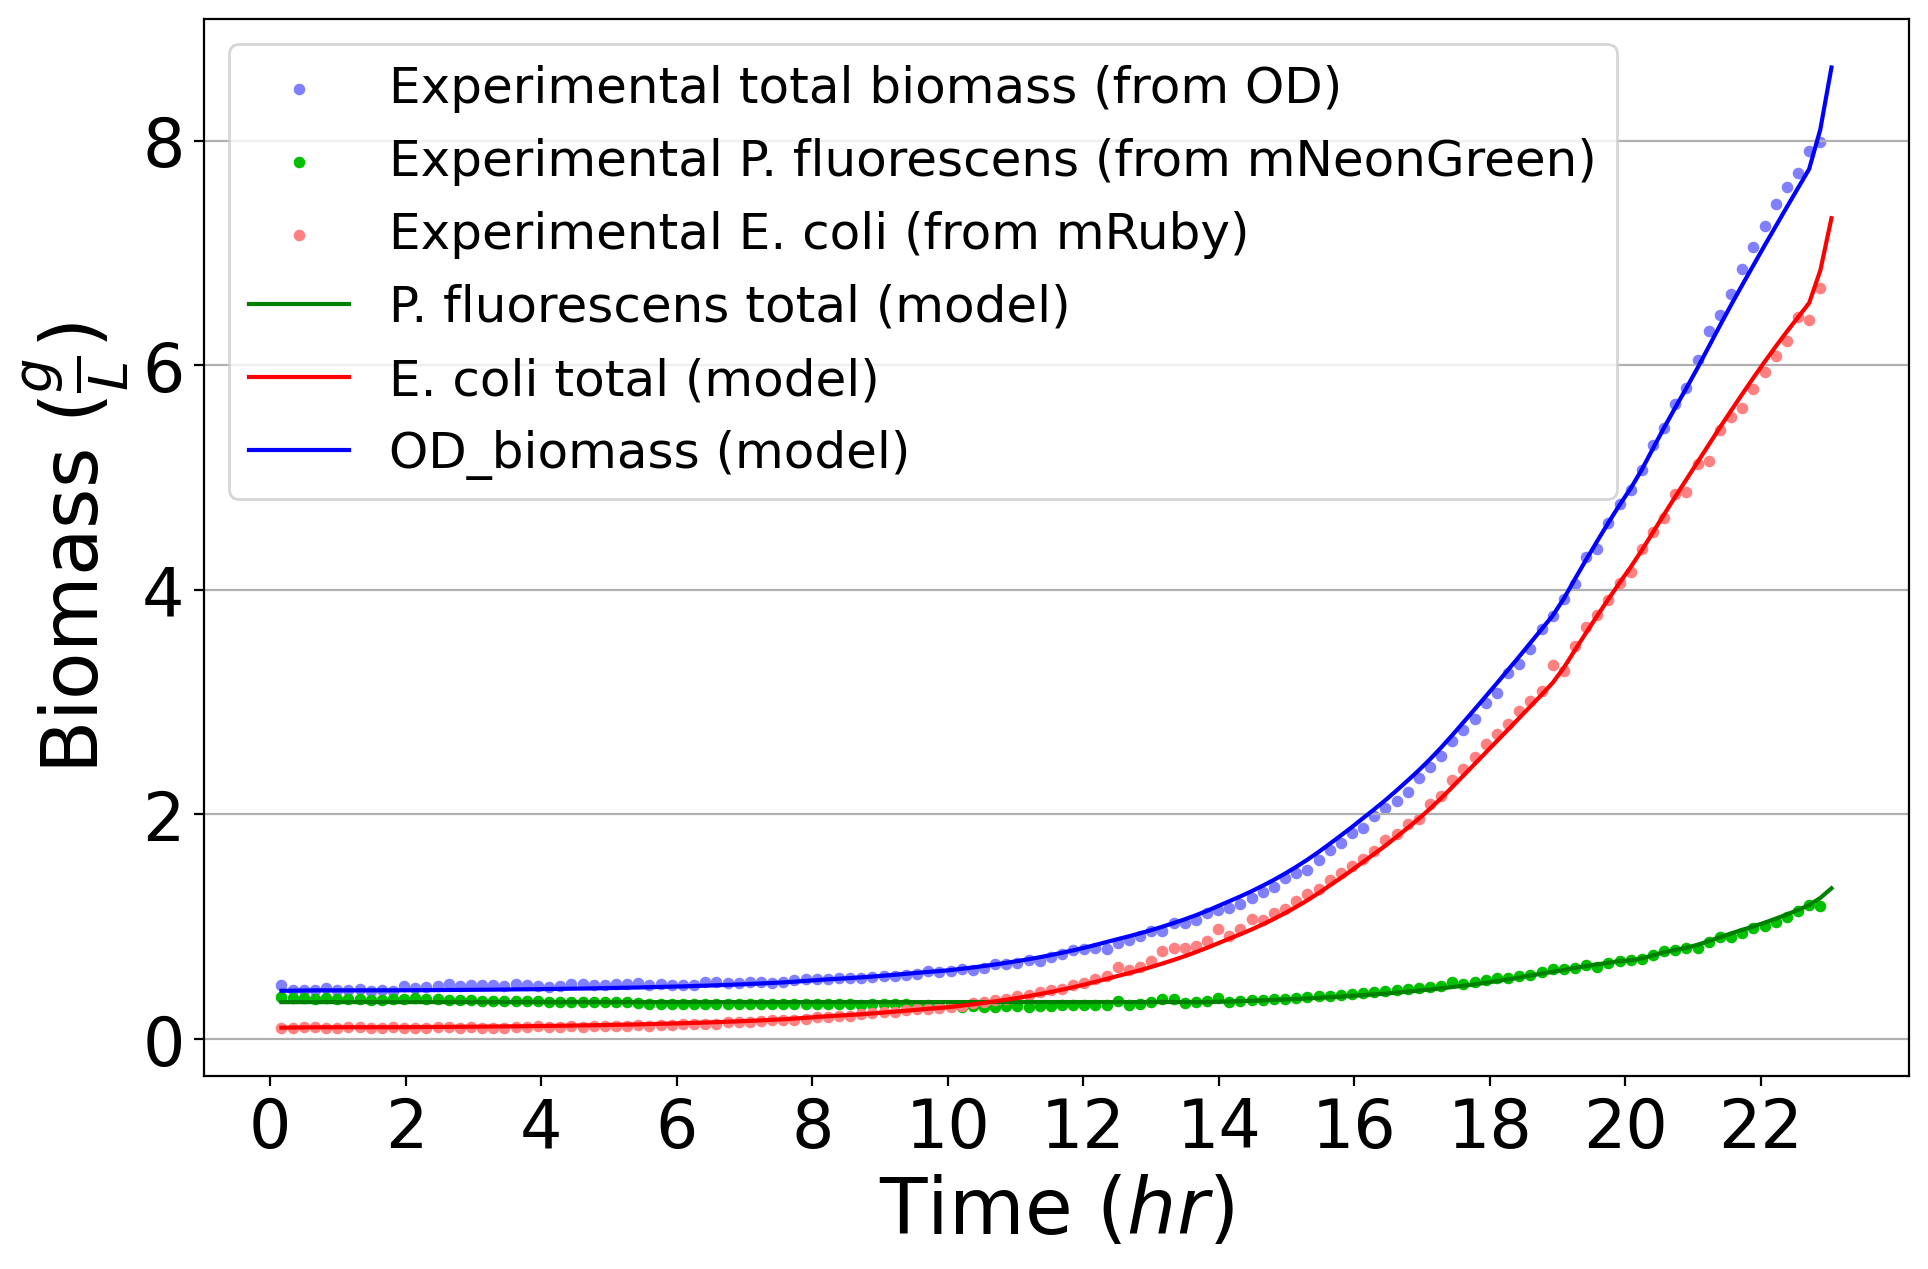

In [4]:
%run mscommfitting.py

maltose_4HB_commfit = CommPhitting(fluxes_df, standardized_carbon_conc, media_conc, growth_df, experimental_metadata)
maltose_4HB_commfit.fit_kinetics(
    parameters={
        'v':.4,
        'cvmin': .1,
        'bcv': 0.0001,
        'diffpos': 100,
        'diffneg': 100
        }, 
     mets_to_track = ["cpd00179","cpd00029"],
     rel_final_conc = {"cpd00179":0.2},
     zero_start=["cpd00029"],
    abs_final_conc={"cpd00029":0.5}, # metabolomics data
       graphs = update_graphs("G4", None), 
     export_zip_name='simple_kinetics_loop.zip', 
     # data_timesteps = {"A3":list(range(10))},
    msdb_path='../../../ModelSEED/ModelSEEDDatabase',
    publishing=True)